## README

Due to the high computational power requirements, this notebook will not run in standard/free edition in Google Colab and will required higher computation capacity. We have kept the cell outputs in this notebook for investigation, if re-running in your system is not possible at this time!

We have used following system for this notebook:

- Google Console Platform - Vertex AI Jupyter Notebook
  - Machine type: n1-standard-16 (16 vCPUs, 60 GB RAM)
  - GPU: NVIDIA Tesla P100 x 1
  - Environment: TensorFlow Enterprise 2.16 (Intel® MKL-DNN/MKL)
  - CUDA Version 12

Following steps are required for your system dependencies. If you have done this step ones, or you are confident with your current system dependencies you can move to next code block!

This may take some time, please bear with us!

    If you have a conda capable environment, you can simply load the .yaml file to your
    conda environment without installing all libraries individually!

In [ ]:
## Implement your conda env here to read tensorflow_fl_env.yaml file


In [ ]:
#@title Run this if you can't use conda (SKIP IF YOU PASS CELL ABOVE!)
import yaml

# Load and convert the uploaded environment.yaml
with open("/github_brainfl/Membership_inference/tensorflow_fl_env.yaml", 'r') as file:
    env_config = yaml.safe_load(file)

pip_deps = []

# Loop through the YAML structure
for dep in env_config['dependencies']:
    if isinstance(dep, dict) and 'pip' in dep:
        # Only use pip-compatible dependencies
        pip_deps.extend(dep['pip'])

# Print and install
print("Installing pip dependencies:")
for pkg in pip_deps:
    print(f"  - {pkg}")
    !pip install {pkg}



with open("/github_brainfl/Membership_inference/requirements.txt", "w") as f:
    for package in pip_deps:
        f.write(package + "\n")

# Imports and Functions

In [ ]:
import os

os.environ["GRPC_MAX_RECEIVE_MESSAGE_LENGTH"] = "4000000000"
os.environ["GRPC_MAX_SEND_MESSAGE_LENGTH"] = "4000000000"
os.environ["GRPC_DEFAULT_COMPRESSION_ALGORITHM"] = "gzip"


import sys
import numpy as np
import pickle
import gc
import logging
from typing import Tuple, List, Dict, Union, Optional
from dataclasses import dataclass
from collections import defaultdict

# Configure logging with more detail
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s'
)
logger = logging.getLogger(__name__)

# TensorFlow memory management
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logger.info("GPU memory growth enabled")

# Local TF-privacy path setup
LOCAL_TFPATH = '/home/jupyter/MInference_module'
if LOCAL_TFPATH not in sys.path:
    sys.path.insert(0, LOCAL_TFPATH)

# TensorFlow Federated setup
import tensorflow_federated as tff
from tensorflow.keras import backend as K

# TF Privacy imports
import tensorflow_privacy
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import (
    membership_inference_attack as mia,
    privacy_report
)
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import (
    AttackInputData,
    AttackResultsCollection,
    PrivacyMetric,
    AttackType,
    PrivacyReportMetadata,
    SlicingSpec
)

# Metrics and visualization
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from scipy import special
from sklearn.model_selection import KFold
import seaborn as sns

# Suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
np.seterr(divide='ignore', invalid='ignore')

# Memory patch for TFF
import tensorflow_federated.python.core.impl.executors.value_serialization as vs

# Keras imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv2D, Flatten, MaxPooling2D, Dropout,
    BatchNormalization, Activation, Input, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

from tensorflow_federated.python.learning import algorithms



import tensorflow_federated.python.core.impl.executors.value_serialization as vs

2025-02-24 00:51:21.827120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 00:51:21.827168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 00:51:21.827206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 00:51:21.838160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 00:51:24.173038: I tensorflow/compiler/

## Data Loader Functions

In [ ]:
def load_data(images_path, labels_path):
    """Load images and labels from pickle files."""
    with open(images_path, 'rb') as f:
        images = pickle.load(f)
    with open(labels_path, 'rb') as f:
        labels = pickle.load(f)
    return images, labels

def preprocess_client_data(images, labels, batch_size=32):
    """Preprocess client data: expand dims (channel) and cast types."""
    # Assuming images are grayscale; add channel dimension and cast to float16.
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(
        lambda x, y: (tf.cast(tf.expand_dims(x, -1), tf.float16), tf.cast(y, tf.int16))
    )
    return dataset.batch(batch_size)

def preprocess_test_data(images, labels, batch_size=32):
    """Preprocess test data similarly."""
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(
        lambda x, y: (tf.cast(tf.expand_dims(x, -1), tf.float16), tf.cast(y, tf.int16))
    )
    return dataset.batch(batch_size)


In [ ]:
def create_client_dataset(client_id, client_data, batch_size, num_samples, local_epochs=1, take_batches=None):
    """
    Create a client dataset by stratified sampling.

    Args:
        client_id: Identifier for reproducibility.
        client_data: Tuple (images, labels) for the client.
        batch_size: Batch size for the dataset.
        num_samples: Number of samples to draw.
        local_epochs: Number of times to repeat the dataset.
        take_batches: If provided, limits the number of batches.

    Returns:
        A tf.data.Dataset instance.
    """
    from sklearn.model_selection import train_test_split

    images, labels = client_data
    images = np.array(images)
    labels = np.array(labels)

    # Use train_test_split to sample indices while preserving class balance.
    _, sampled_indices = train_test_split(
        np.arange(len(labels)),
        test_size=num_samples,
        stratify=labels,
        random_state=int(client_id)
    )

    # Prepare tensors.
    x = tf.convert_to_tensor(images[sampled_indices], dtype=tf.float16)
    x = tf.expand_dims(x, -1)  # Add channel dimension.
    y = tf.convert_to_tensor(labels[sampled_indices], dtype=tf.int16)

    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.batch(batch_size)
    if take_batches is not None:
        dataset = dataset.take(take_batches)
    # Repeat the dataset for local_epochs.
    dataset = dataset.repeat(local_epochs)
    return dataset


In [ ]:
def sample_data_for_mia(member_data, nonmember_data, sample_size, seed=None):
    """
    Samples balanced subsets for membership inference.

    Args:
        member_data: Tuple (member_images, member_labels) for members.
        nonmember_data: Tuple (nonmember_images, nonmember_labels) for non-members.
        sample_size: Number of samples to draw for each group.
        seed: Random seed for reproducibility.

    Returns:
        A tuple of sampled data: ((member_images_sampled, member_labels_sampled),
                                     (nonmember_images_sampled, nonmember_labels_sampled)).
    """
    rng = np.random.default_rng(seed)
    member_images, member_labels = member_data
    nonmember_images, nonmember_labels = nonmember_data

    num_member = min(sample_size, len(member_images))
    num_nonmember = min(sample_size, len(nonmember_images))

    member_indices = rng.choice(len(member_images), num_member, replace=False)
    nonmember_indices = rng.choice(len(nonmember_images), num_nonmember, replace=False)

    return (member_images[member_indices], member_labels[member_indices]), \
           (nonmember_images[nonmember_indices], nonmember_labels[nonmember_indices])


## Model Definitions

In [ ]:
def create_model():
    """Creates a CNN model for brain MRI classification."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
    ])
    return model


In [ ]:
def model_fn():
    """Wraps the Keras model for TensorFlow Federated."""
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=(
            tf.TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float16),
            tf.TensorSpec(shape=(None,), dtype=tf.int16)
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


In [ ]:
def convert_state_to_model(state):
    """
    Converts a federated learning state to a centralized Keras model.
    Assumes state.global_model_weights.trainable is in the correct order.
    """
    keras_model = create_model()
    try:
        keras_model.set_weights(state.global_model_weights.trainable)
    except Exception as e:
        logger.error("Error setting weights: " + str(e))
        raise
    keras_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    return keras_model


In [ ]:
def preprocess_for_tff(dataset):
    """
    Performs minimal transformations to ensure the dataset is ready for TFF.
    In this case, we simply prefetch for performance.
    """
    return dataset.prefetch(tf.data.AUTOTUNE)


## MIA Framework

In [ ]:
from scipy import special
from sklearn.metrics import confusion_matrix, roc_curve

class FederatedPrivacyEvaluator:
    def __init__(self,
                 epochs_per_report: int,
                 model_name: str,
                 batch_size: int = 32,
                 sample_size: int = 500):
        """Enhanced MIA evaluator for federated learning."""
        self.epochs_per_report = epochs_per_report
        self.model_name = model_name
        self.batch_size = batch_size
        self.sample_size = sample_size

        # Results storage with version tracking
        self.results = {
            'client': defaultdict(list),  # {version: [epoch][client_idx] => AttackResults}
            'global': defaultdict(list)   # {version: [epoch] => AttackResults}
        }
        self.confusion_matrices = {
            'client': defaultdict(list),
            'global': defaultdict(list)
        }
        self.metrics = {
            'client': defaultdict(lambda: defaultdict(list)),
            'global': defaultdict(lambda: defaultdict(list))
        }

        # Dynamic thresholds per version
        self.thresholds = defaultdict(lambda: {
            'client': {},
            'global': 0.5
        })

    def find_optimal_threshold(self, y_true, y_scores):
        if len(y_true) < 2 or len(np.unique(y_true)) < 2:
            logger.warning("Insufficient data for threshold optimization")
            return 0.5
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        differences = tpr - fpr
        optimal_idx = np.argmax(differences)
        logger.debug(f"Threshold optimization - Max difference: {differences[optimal_idx]:.4f}")
        return thresholds[optimal_idx]

    def evaluate_privacy(self, model, member_data: Tuple[np.ndarray, np.ndarray],
                         nonmember_data: Tuple[np.ndarray, np.ndarray],
                         epoch: int, version: str, client_id: Union[int, str] = None):
        try:
            x_mem, y_mem = member_data
            x_nonmem, y_nonmem = nonmember_data

            logits_mem = model.predict(x_mem, batch_size=self.batch_size)
            logits_nonmem = model.predict(x_nonmem, batch_size=self.batch_size)

            probs_mem = special.softmax(logits_mem, axis=1)
            probs_nonmem = special.softmax(logits_nonmem, axis=1)

            logger.info(f"Member predictions - Mean: {probs_mem.mean():.4f}, Std: {probs_mem.std():.4f}")
            logger.info(f"Non-member predictions - Mean: {probs_nonmem.mean():.4f}, Std: {probs_nonmem.std():.4f}")

            attack_input = AttackInputData(
                labels_train=y_mem,
                labels_test=y_nonmem,
                probs_train=probs_mem,
                probs_test=probs_nonmem
            )

            train_preds = np.argmax(probs_mem, axis=1)
            test_preds = np.argmax(probs_nonmem, axis=1)
            acc_mem = np.mean(train_preds == y_mem)
            acc_nonmem = np.mean(test_preds == y_nonmem)

            attack_results = mia.run_attacks(
                attack_input,
                SlicingSpec(entire_dataset=True),
                attack_types=(
                    AttackType.THRESHOLD_ATTACK,
                    AttackType.LOGISTIC_REGRESSION,
                    AttackType.MULTI_LAYERED_PERCEPTRON
                ),
                privacy_report_metadata=PrivacyReportMetadata(
                    epoch_num=epoch,
                    accuracy_train=acc_mem,
                    accuracy_test=acc_nonmem,
                    model_variant_label=f"{self.model_name}-{version}-{'Global' if client_id=='global' else f'Client {client_id}'}"
                )
            )

            max_probs_mem = np.max(probs_mem, axis=1)
            max_probs_nonmem = np.max(probs_nonmem, axis=1)
            all_probs = np.concatenate([max_probs_mem, max_probs_nonmem])
            all_labels = np.concatenate([np.ones_like(y_mem), np.zeros_like(y_nonmem)])

            threshold = self.find_optimal_threshold(all_labels, all_probs)
            if client_id == 'global':
                self.thresholds[version]['global'] = threshold
            else:
                self.thresholds[version]['client'][client_id] = threshold

            pred_member = (all_probs >= threshold).astype(int)
            cm = confusion_matrix(all_labels, pred_member)
            tn, fp, fn, tp = cm.ravel()

            conf_dict = {
                "tp": int(tp), "fp": int(fp),
                "tn": int(tn), "fn": int(fn),
                "threshold": float(threshold),
                "acc_mem": float(acc_mem),
                "acc_nonmem": float(acc_nonmem),
                "mean_confidence_mem": float(max_probs_mem.mean()),
                "mean_confidence_nonmem": float(max_probs_nonmem.mean()),
                "confidence_gap": float(max_probs_mem.mean() - max_probs_nonmem.mean())
            }

            return attack_results, conf_dict

        except Exception as e:
            logger.error(f"Privacy evaluation failed: {e}")
            logger.error("Stack trace:", exc_info=True)
            return None, None

    def evaluate_epoch(self, epoch: int, model: tf.keras.Model,
                       client_data: Dict[int, Tuple[np.ndarray, np.ndarray]],
                       test_data: Tuple[np.ndarray, np.ndarray],
                       version: str, client_id: Union[int, str] = None):
        if epoch % self.epochs_per_report != 0:
            return

        try:
            if isinstance(client_id, int):
                member_data = client_data[client_id]
                nonmember_data = test_data
                member_sample, nonmember_sample = sample_data_for_mia(member_data, nonmember_data, self.sample_size, seed=epoch*100 + client_id)
                results, conf_dict = self.evaluate_privacy(model, member_sample, nonmember_sample, epoch, version, client_id)
                while len(self.results['client'][version]) <= epoch:
                    self.results['client'][version].append([])
                    self.confusion_matrices['client'][version].append([])
                while len(self.results['client'][version][epoch]) <= client_id:
                    self.results['client'][version][epoch].append(None)
                    self.confusion_matrices['client'][version][epoch].append(None)
                self.results['client'][version][epoch][client_id] = results
                self.confusion_matrices['client'][version][epoch][client_id] = conf_dict
            elif client_id == "global":
                all_member_images = []
                all_member_labels = []
                for client_imgs, client_lbls in client_data.values():
                    all_member_images.append(client_imgs)
                    all_member_labels.append(client_lbls)
                member_data = (np.concatenate(all_member_images), np.concatenate(all_member_labels))
                member_sample, nonmember_sample = sample_data_for_mia(member_data, test_data, self.sample_size, seed=epoch*100)
                results, conf_dict = self.evaluate_privacy(model, member_sample, nonmember_sample, epoch, version, "global")
                while len(self.results['global'][version]) <= epoch:
                    self.results['global'][version].append(None)
                    self.confusion_matrices['global'][version].append(None)
                self.results['global'][version][epoch] = results
                self.confusion_matrices['global'][version][epoch] = conf_dict
        except Exception as e:
            logger.error(f"Epoch evaluation failed: {e}")
            logger.error("Stack trace:", exc_info=True)


## Functions to Plot Results

In [ ]:
def visualize_privacy_metrics(privacy_evaluator, global_accuracies, client_accuracies, title_pref: str = None):
    """Visualization of privacy metrics for model performance using the 'original' results."""

    def compute_metrics(conf_dict):
        if not conf_dict:
            return None
        try:
            tp = conf_dict["tp"]
            fp = conf_dict["fp"]
            tn = conf_dict["tn"]
            fn = conf_dict["fn"]
        except Exception as e:
            logger.error(f"Error extracting metrics from conf_dict: {e}")
            return None

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        vulnerability = tpr - fpr
        f1_score = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        return {
            "tpr": tpr,
            "fpr": fpr,
            "precision": precision,
            "vulnerability": vulnerability,
            "f1_score": f1_score
        }

    def extract_attack_metrics(attack_results):
        if not attack_results:
            return {}
        metrics = {}
        for attack in attack_results.single_attack_results:
            attack_type = str(attack.attack_type).split('.')[-1]
            metrics[attack_type] = {
                'ppv': 0.5,
                'auc': attack.roc_curve.get_auc() if hasattr(attack.roc_curve, 'get_auc') else 0.5,
                'advantage': attack.get_attacker_advantage() if hasattr(attack, 'get_attacker_advantage') else 0
            }
        return metrics

    # Get default color cycle from matplotlib
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    version = "original"

    client_results_all = privacy_evaluator.results['client'].get(version, [])
    client_confusions_all = privacy_evaluator.confusion_matrices['client'].get(version, [])
    valid_client_results = [r for r in client_results_all if r]
    valid_client_confusions = [r for r in client_confusions_all if r]

    if not valid_client_results or not valid_client_confusions:
        logger.error("No valid client results available for visualization.")
        return

    num_rounds = len(valid_client_results)
    num_clients = len(valid_client_results[0])

    for client_id in range(num_clients):
        # Increased figure width for better visualization
        fig, axes = plt.subplots(2, 3, figsize=(24, 16))
        fig.suptitle(f'Client {client_id} Privacy Metrics - {title_pref}', fontsize=18)

        metrics_list = []
        for round_data in valid_client_confusions:
            if isinstance(round_data, list) and len(round_data) > client_id and round_data[client_id]:
                met = compute_metrics(round_data[client_id])
                if met is not None:
                    metrics_list.append(met)

        if metrics_list:
            # Use different colors from the default cycle for each metric.
            axes[0,0].plot([m["tpr"] for m in metrics_list], '--o', color=default_colors[0], label='TPR')
            axes[0,0].plot([m["fpr"] for m in metrics_list], '-o', alpha=0.5, color=default_colors[1], label='FPR')
            axes[0,0].set_title(f'True/False Positive Rates', fontsize=14)
            axes[0,0].set_xlabel('Round', fontsize=12)
            axes[0,0].legend(fontsize=12)
            axes[0,0].grid(True)

            axes[0,1].plot([m["vulnerability"] for m in metrics_list], '-o', color=default_colors[2], label='Vulnerability')
            axes[0,1].set_title(f'Privacy Vulnerability (TPR-FPR)', fontsize=14)
            axes[0,1].set_xlabel('Round', fontsize=12)
            axes[0,1].legend(fontsize=12)
            axes[0,1].grid(True)

            axes[0,2].plot([m["f1_score"] for m in metrics_list], '-o', color=default_colors[3 % len(default_colors)], label='F1 Score')
            axes[0,2].set_title(f'Attack F1 Score', fontsize=14)
            axes[0,2].set_xlabel('Round', fontsize=12)
            axes[0,2].legend(fontsize=12)
            axes[0,2].grid(True)
        else:
            for i, title in enumerate(["True/False Positive Rates", "Privacy Vulnerability (TPR-FPR)", "Attack F1 Score"]):
                axes[0,i].text(0.5, 0.5, "No valid confusion matrices available", ha='center', va='center', fontsize=12)
                axes[0,i].set_title(title, fontsize=14)

        attack_metrics = []
        for round_data in valid_client_results:
            if isinstance(round_data, list) and len(round_data) > client_id and round_data[client_id]:
                res = round_data[client_id]
                try:
                    attack_metrics.append(extract_attack_metrics(res))
                except Exception as e:
                    logger.error(f"Error extracting attack metrics: {e}")

        if attack_metrics:
            for i, attack_type in enumerate(['THRESHOLD_ATTACK', 'LOGISTIC_REGRESSION', 'MULTI_LAYERED_PERCEPTRON']):
                auc_values = [m.get(attack_type, {}).get('auc', 0.5) for m in attack_metrics if attack_type in m]
                adv_values = [m.get(attack_type, {}).get('advantage', 0) for m in attack_metrics if attack_type in m]

                if auc_values:
                    axes[1,0].plot(range(1, len(auc_values) + 1), auc_values, '-', label=f'{attack_type} AUC', alpha=0.7, color=default_colors[i % len(default_colors)])
                if adv_values:
                    axes[1,1].plot(range(1, len(adv_values) + 1), adv_values, '-', label=f'{attack_type} Advantage', alpha=0.7, color=default_colors[i % len(default_colors)])

            axes[1,0].set_title(f'Attack AUC', fontsize=14)
            axes[1,0].set_xlabel('Round', fontsize=12)
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            axes[1,0].grid(True)

            axes[1,1].set_title(f'Attacker Advantage', fontsize=14)
            axes[1,1].set_xlabel('Round', fontsize=12)
            axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            axes[1,1].grid(True)
        else:
            axes[1,0].text(0.5, 0.5, "No attack metrics available", ha='center', va='center', fontsize=12)
            axes[1,0].set_title(f'Attack AUC', fontsize=14)
            axes[1,1].text(0.5, 0.5, "No attack metrics available", ha='center', va='center', fontsize=12)
            axes[1,1].set_title(f'Attacker Advantage', fontsize=14)

        # For model accuracy vs vulnerability, use distinct colors for each metric.
        if client_accuracies and len(client_accuracies) > client_id:
            axes[1,2].plot([acc[1] for acc in client_accuracies[client_id]], label='Accuracy', linestyle='-', color=default_colors[0])
        if metrics_list:
            axes[1,2].plot([m["vulnerability"] for m in metrics_list], label='Vulnerability', linestyle='--', color=default_colors[1])
        axes[1,2].set_title(f'Model Accuracy vs Vulnerability', fontsize=14)
        axes[1,2].set_xlabel('Round', fontsize=12)
        axes[1,2].legend(fontsize=12)
        axes[1,2].grid(True)

        plt.tight_layout()
        plt.show()

    # Global-level visualization
    global_conf = [r for r in privacy_evaluator.confusion_matrices['global'].get(version, []) if r]
    global_results_all = [r for r in privacy_evaluator.results['global'].get(version, []) if r]
    metrics_global = [compute_metrics(cm) for cm in global_conf if cm]
    metrics_global = [m for m in metrics_global if m is not None]

    if metrics_global:
        fig, axes = plt.subplots(2, 3, figsize=(24, 16))
        fig.suptitle(f'Global Model Privacy Metrics - {title_pref}', fontsize=18)

        axes[0,0].plot([m["tpr"] for m in metrics_global], '--o', color=default_colors[0], label='TPR')
        axes[0,0].plot([m["fpr"] for m in metrics_global], '-o', alpha=0.5, color=default_colors[1], label='FPR')
        axes[0,0].set_title(f'True/False Positive Rates', fontsize=14)
        axes[0,0].set_xlabel('Round', fontsize=12)
        axes[0,0].legend(fontsize=12)
        axes[0,0].grid(True)

        axes[0,1].plot([m["vulnerability"] for m in metrics_global], '-o', color=default_colors[2], label='Vulnerability')
        axes[0,1].set_title(f'Privacy Vulnerability (TPR-FPR)', fontsize=14)
        axes[0,1].set_xlabel('Round', fontsize=12)
        axes[0,1].legend(fontsize=12)
        axes[0,1].grid(True)

        axes[0,2].plot([m["f1_score"] for m in metrics_global], '-o', color=default_colors[3 % len(default_colors)], label='F1 Score')
        axes[0,2].set_title(f'Attack F1 Score', fontsize=14)
        axes[0,2].set_xlabel('Round', fontsize=12)
        axes[0,2].legend(fontsize=12)
        axes[0,2].grid(True)

        attack_metrics_global = []
        for res in global_results_all:
            try:
                attack_metrics_global.append(extract_attack_metrics(res))
            except Exception as e:
                logger.error(f"Error extracting global attack metrics: {e}")

        if attack_metrics_global:
            for i, attack_type in enumerate(['THRESHOLD_ATTACK', 'LOGISTIC_REGRESSION', 'MULTI_LAYERED_PERCEPTRON']):
                auc_values = [m.get(attack_type, {}).get('auc', 0.5) for m in attack_metrics_global if attack_type in m]
                adv_values = [m.get(attack_type, {}).get('advantage', 0) for m in attack_metrics_global if attack_type in m]

                if auc_values:
                    axes[1,0].plot(range(1, len(auc_values) + 1), auc_values, '-', label=f'{attack_type} AUC', alpha=0.7, color=default_colors[i % len(default_colors)])
                if adv_values:
                    axes[1,1].plot(range(1, len(adv_values) + 1), adv_values, '-', label=f'{attack_type} Advantage', alpha=0.7, color=default_colors[i % len(default_colors)])

            axes[1,0].set_title(f'Attack AUC', fontsize=14)
            axes[1,0].set_xlabel('Round', fontsize=12)
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            axes[1,0].grid(True)

            axes[1,1].set_title(f'Attacker Advantage', fontsize=14)
            axes[1,1].set_xlabel('Round', fontsize=12)
            axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            axes[1,1].grid(True)
        else:
            axes[1,0].text(0.5, 0.5, "No global attack metrics available", ha='center', va='center', fontsize=12)

        if global_accuracies:
            axes[1,2].plot(global_accuracies, label='Global Accuracy', linestyle='-', color=default_colors[0])
        if metrics_global:
            axes[1,2].plot([m["vulnerability"] for m in metrics_global], label='Vulnerability', linestyle='--', color=default_colors[1])

        axes[1,2].set_title(f'Model Accuracy vs Vulnerability', fontsize=14)
        axes[1,2].set_xlabel('Round', fontsize=12)
        axes[1,2].legend(fontsize=12)
        axes[1,2].grid(True)
        plt.tight_layout()
        plt.show()
    else:
        logger.warning("No valid global confusion matrices available")


In [ ]:
def visualize_default_mia(privacy_evaluator):
    """Visualize default TFP MIA metrics."""

    def inspect_and_fix_results(results):
        """Inspect and attempt to fix results with missing privacy metadata"""
        fixed_results = []
        for i, result in enumerate(results):
            if not result:
                continue

            # Try to fix privacy metadata if missing
            if hasattr(result, 'single_attack_results'):
                fixed = False
                for attack in result.single_attack_results:
                    if not hasattr(attack, 'privacy_report_metadata') or attack.privacy_report_metadata is None:
                        # Create minimal privacy metadata if needed
                        try:
                            attack.privacy_report_metadata = PrivacyReportMetadata(
                                accuracy_train=0.5,
                                accuracy_test=0.5,
                                epoch_num=i
                            )
                            fixed = True
                        except:
                            pass
                if fixed:
                    fixed_results.append(result)
                else:
                    fixed_results.append(result)  # Add it anyway as it might work

        return fixed_results

    def reorder_list(data):
        if not data or len(data) == 0:
            return []
        num_clients = max(len(epoch_data) for epoch_data in data if isinstance(epoch_data, list))
        reordered = [[] for _ in range(num_clients)]
        for epoch_data in data:
            if not isinstance(epoch_data, list):
                continue
            for client_idx, val in enumerate(epoch_data):
                if client_idx < num_clients:
                    reordered[client_idx].append(val)
        return reordered

    privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)

    # Hard-code the version to "original"
    version = "original"

    if version not in privacy_evaluator.results['client']:
        logger.warning(f"Version {version} not found in client results")
        return

    client_reports = reorder_list(privacy_evaluator.results['client'][version])

    for client_id, client_list in enumerate(client_reports):
        if not any(client_list):
            logger.warning(f"No valid TFP results for Client {client_id}")
            continue

        # Try to fix the results
        valid_client_results = inspect_and_fix_results([r for r in client_list if r])

        if not valid_client_results:
            logger.warning(f"Could not fix attack results for Client {client_id}")
            continue

        try:
            arc = AttackResultsCollection(valid_client_results)
            fig_tfp = privacy_report.plot_by_epochs(arc, privacy_metrics=privacy_metrics)
            fig_tfp.suptitle(f"Client {client_id} TFP Metrics")

            for ax in fig_tfp.get_axes():
                ax.grid(True, alpha=0.3)

            plt.show()
        except Exception as e:
            logger.error(f"Error plotting TFP metrics for Client {client_id}: {e}")
            logger.error("Stack trace:", exc_info=True)

    # Global model visualization
    if version not in privacy_evaluator.results['global']:
        logger.warning(f"Version {version} not found in global results")
        return

    global_results = privacy_evaluator.results['global'][version]

    # Try to fix the global results
    valid_global_results = inspect_and_fix_results([r for r in global_results if r])

    if valid_global_results:
        try:
            arc_global = AttackResultsCollection(valid_global_results)
            fig_global = privacy_report.plot_by_epochs(arc_global, privacy_metrics=privacy_metrics)
            fig_global.suptitle("Global Model TFP Metrics")

            for ax in fig_global.get_axes():
                ax.grid(True, alpha=0.3)

            plt.show()
        except Exception as e:
            logger.error(f"Error plotting TFP metrics for Global Model: {e}")
            logger.error("Stack trace:", exc_info=True)
    else:
        logger.warning(f"Could not fix global results")

## Training Loop Definition

In [ ]:
def train_federated_model(
    num_rounds: int = 30,
    client_batch_size: int = 16,
    local_epochs: int = 2,
    train_data_version: str = "gs",
    eval_data_version: str = "gs",
    mia_member_version: str = "original",
    mia_nonmem_version: str = "original",
    num_clients: int = 3
):
    """
    Runs federated training using TFF aggregation with integrated MIA evaluation
    via FederatedPrivacyEvaluator.
    Model training uses the data version specified by train_data_version and eval_data_version,
    while privacy evaluations use data loaded from mia_member_version (for member data)
    and mia_nonmem_version (for non-member data).
    """
    # Clear sessions and collect garbage.
    tf.keras.backend.clear_session()
    gc.collect()

    logger.info(f"Starting federated training with {num_clients} clients")
    logger.info(f"Training with {train_data_version} data, evaluating with {eval_data_version} data")

    # Initialize the federated averaging process.
    iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=5e-4),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

    # Load training data for each client for model training (using gs version)
    train_data = {}
    for client_idx in range(num_clients):
        images, labels = load_data_version(train_data_version, client_idx)
        train_data[client_idx] = (images, labels)

    # Load evaluation data for model training (using gs version)
    test_images, test_labels = load_data_version(eval_data_version)
    eval_data = tf.data.Dataset.from_tensor_slices((
        tf.cast(np.array(test_images), tf.float32),
        tf.cast(np.array(test_labels), tf.int32)
    )).batch(client_batch_size)
    eval_data_arrays = (np.array(test_images), np.array(test_labels))

    # --- NEW: Load data for MIA evaluation ---
    # Load member data for privacy evaluation (original version)
    train_data_mia = {}
    for client_idx in range(num_clients):
        images_mia, labels_mia = load_data_version(mia_member_version, client_idx)
        train_data_mia[client_idx] = (images_mia, labels_mia)

    # Load non-member data for privacy evaluation (original version)
    test_images_mia, test_labels_mia = load_data_version(mia_nonmem_version)
    eval_data_mia = tf.data.Dataset.from_tensor_slices((
        tf.cast(np.array(test_images_mia), tf.float32),
        tf.cast(np.array(test_labels_mia), tf.int32)
    )).batch(client_batch_size)
    eval_data_arrays_mia = (np.array(test_images_mia), np.array(test_labels_mia))
    # ------------------------------------------------

    # Initialize the privacy evaluator.
    privacy_evaluator = FederatedPrivacyEvaluator(
        epochs_per_report=1,
        model_name=f"Federated_Xray_{train_data_version}",
        batch_size=client_batch_size,
        sample_size=500
    )

    # Initialize state and global model.
    state = iterative_process.initialize()
    global_model = convert_state_to_model(state)
    client_accuracies = [[] for _ in range(num_clients)]
    global_accuracies = []

    # Training loop.
    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Starting Federated Round {round_num} ---")
        logger.info(f"\n--- Round {round_num}/{num_rounds} ---")
        federated_data = []

        # Client training loop.
        for client_idx in range(num_clients):
            print(f"Training Client {client_idx} for Round {round_num}")
            logger.info(f"\nTraining Client {client_idx}")
            try:
                local_model = convert_state_to_model(state)
                if not local_model:
                    logger.error(f"Failed to create local model for Client {client_idx}")
                    continue

                # Dataset for TFF aggregation (lighter version).
                tff_dataset = create_client_dataset(
                    client_id=client_idx,
                    client_data=train_data[client_idx],
                    batch_size=client_batch_size,
                    num_samples=500,
                    local_epochs=2,
                    take_batches=50
                )
                processed_tff_dataset = preprocess_for_tff(tff_dataset)
                federated_data.append(processed_tff_dataset)

                # Full local training dataset.
                train_dataset = create_client_dataset(
                    client_id=client_idx,
                    client_data=train_data[client_idx],
                    batch_size=client_batch_size,
                    num_samples=500,
                    local_epochs=local_epochs
                )

                history = local_model.fit(
                    train_dataset,
                    validation_data=eval_data,
                    epochs=local_epochs,
                    verbose=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            min_delta=1e-3,
                            restore_best_weights=True
                        ),
                        tf.keras.callbacks.LearningRateScheduler(lambda epoch: 5e-4 * (0.9 ** epoch))
                    ]
                )

                final_train_acc = history.history['sparse_categorical_accuracy'][-1]
                final_val_acc = history.history['val_sparse_categorical_accuracy'][-1]
                client_accuracies[client_idx].append((final_train_acc, final_val_acc))
                logger.info(f"Client {client_idx} - Train acc: {final_train_acc:.4f}, Val acc: {final_val_acc:.4f}")

                # Client MIA evaluation (using original data for privacy eval)
                privacy_evaluator.evaluate_epoch(
                    epoch=round_num,
                    model=local_model,
                    client_data=train_data_mia,
                    test_data=eval_data_arrays_mia,
                    version=mia_nonmem_version,
                    client_id=client_idx
                )
            except Exception as e:
                logger.error(f"Error in client {client_idx} training: {str(e)}")
                logger.error("Stack trace:", exc_info=True)
                continue
            finally:
                if 'local_model' in locals():
                    del local_model
                gc.collect()
                tf.keras.backend.clear_session()

        # Global aggregation.
        try:
            state, metrics = iterative_process.next(state, federated_data)
            logger.info(f"Round {round_num} TFF metrics: {metrics}")
            state.global_model_weights.assign_weights_to(global_model)
            global_metrics = global_model.evaluate(eval_data, verbose=1)
            global_loss, global_acc = global_metrics[0], global_metrics[1]
            global_accuracies.append(global_acc)
            logger.info(f"Round {round_num}: Global Loss = {global_loss:.4f}, Accuracy = {global_acc:.4f}")

            # Global MIA evaluation (using original data for privacy eval)
            privacy_evaluator.evaluate_epoch(
                epoch=round_num,
                model=global_model,
                client_data=train_data_mia,
                test_data=eval_data_arrays_mia,
                version=mia_nonmem_version,
                client_id="global"
            )
        except Exception as e:
            logger.error(f"TFF aggregation failed at round {round_num}: {str(e)}")
            logger.error("Stack trace:", exc_info=True)

        gc.collect()
        tf.keras.backend.clear_session()

    return privacy_evaluator, global_accuracies, client_accuracies


# Main Execution Block

In [ ]:
#@title Define Data Paths Here

# Define the data paths (using the same paths from the previous framework)
DATA_PATHS = {
    "original": {
        "clients": [
            {
                "images": "/github_brainfl/data/bench/data_client1.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client1.pickle",  ## <-Replace
            },
            {
                "images": "/github_brainfl/data/bench/data_client2.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client2.pickle",  ## <-Replace
            },
            {
                "images": "/github_brainfl/data/bench/data_client3.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client3.pickle",  ## <-Replace
            }
        ],
        "test": {
            "images": "/github_brainfl/data/bench/test_images.pickle",  ## <-Replace
            "labels": "/github_brainfl/data/bench/test_labels.pickle"  ## <-Replace
        }
    },
    "gs": {
        "clients": [
            {
                "images": "/github_brainfl/data/gs/data_client1_gs20p.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client1.pickle",  ## <-Replace
            },
            {
                "images": "/github_brainfl/data/gs/data_client2_gs20p.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client2.pickle",  ## <-Replace
            },
            {
                "images": "/github_brainfl/data/gs/data_client3_gs20p.pickle",  ## <-Replace
                "labels": "/github_brainfl/data/bench/labels_client3.pickle",  ## <-Replace
            }
        ],
        "test": {
            "images": "/github_brainfl/data/gs/test_images_gs20p.pickle",  ## <-Replace
            "labels": "/github_brainfl/data/bench/test_labels.pickle"  ## <-Replace
        }
    }
}

def load_data_version(version, client_idx=None):
    """
    Loads data for the given version.
    If client_idx is provided, returns client data;
    otherwise returns the test data.
    """
    if client_idx is not None:
        client_info = DATA_PATHS[version]["clients"][client_idx]
        images, labels = load_data(client_info["images"], client_info["labels"])
        return images, labels
    else:
        test_info = DATA_PATHS[version]["test"]
        return load_data(test_info["images"], test_info["labels"])


In [ ]:
# Set hyperparameters.
NUM_ROUNDS = 40         # Total federated training rounds.
NUM_CLIENTS = 3         # Number of simulated clients.
BATCH_SIZE = 32         # Client batch size.
LOCAL_EPOCHS = 4        # Number of local epochs for full client training.

# Execute the federated training loop.
# This function will load client and test data using load_data_version,
# build the federated averaging process, and run TFF aggregation with MIA evaluations.
privacy_evaluator, global_accuracies, client_accuracies = train_federated_model(
    num_rounds=NUM_ROUNDS,
    client_batch_size=BATCH_SIZE,
    local_epochs=LOCAL_EPOCHS,
    train_data_version="gs",
    eval_data_version="gs",
    mia_member_version = "original",
    mia_nonmem_version = "original",
    num_clients=NUM_CLIENTS
)

# Optionally, print or plot the results.
print("Global Accuracies per Round:")
print(global_accuracies)

# If desired, you can further process privacy_evaluator.results for MIA analysis.


2025-02-24 00:51:25,790 - INFO - [2359425943.py:22] - Starting federated training with 3 clients
2025-02-24 00:51:25,791 - INFO - [2359425943.py:23] - Training with gs data, evaluating with gs data
2025-02-24 00:51:25.924395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 00:51:25.924699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 00:51:25.924860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node 


--- Starting Federated Round 1 ---
Training Client 0 for Round 1
Epoch 1/4


2025-02-24 00:51:45.205709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2025-02-24 00:51:46.672135: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f39244f7b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-24 00:51:46.672175: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-02-24 00:51:46.677382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 00:51:46.780941: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 10s 84ms/step - loss: 1.3511 - sparse_categorical_accuracy: 0.3315 - val_loss: 1.1556 - val_sparse_categorical_accuracy: 0.4769 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.9553 - sparse_categorical_accuracy: 0.6075 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.7046 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 59ms/step - loss: 0.6121 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.7423 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 59ms/step - loss: 0.3773 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.7438 - val_sparse_categorical_accuracy: 0.7815 - lr: 3.6450e-04


2025-02-24 00:52:05,699 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.8510, Val acc: 0.7815


16/16 [==============================] - 0s 15ms/step


2025-02-24 00:52:07,526 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0808
2025-02-24 00:52:07,526 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0812
2025-02-24 00:52:07,527 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:52:07,528 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:52:07,533 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.509512, attacker advantage=0.04799999999999993 and positive predictive value=0.5204301075268818
2025-02-24 00:52:07,534 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:52:07,536 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:52:07,633 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:52:07,732 - INFO - [membership_inference_attac

Training Client 1 for Round 1
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 1.2940 - sparse_categorical_accuracy: 0.3680 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.6043 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.8243 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.7338 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.5184 - sparse_categorical_accuracy: 0.7780 - val_loss: 0.6899 - val_sparse_categorical_accuracy: 0.7210 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.7550 - val_sparse_categorical_accuracy: 0.7737 - lr: 3.6450e-04


2025-02-24 00:52:32,476 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.8575, Val acc: 0.7737


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:52:34,253 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0759
2025-02-24 00:52:34,254 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0749
2025-02-24 00:52:34,255 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:52:34,256 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:52:34,261 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.53809, attacker advantage=0.09799999999999998 and positive predictive value=0.5447368421052631
2025-02-24 00:52:34,262 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:52:34,264 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:52:34,365 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:52:34,475 - INFO - [membership_inference_attack

Training Client 2 for Round 1
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 1.3269 - sparse_categorical_accuracy: 0.3550 - val_loss: 1.1164 - val_sparse_categorical_accuracy: 0.5509 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.9305 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.7596 - val_sparse_categorical_accuracy: 0.7032 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.6125 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.7352 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3503 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.7456 - val_sparse_categorical_accuracy: 0.7651 - lr: 3.6450e-04


2025-02-24 00:52:59,019 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.8660, Val acc: 0.7651


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:53:00,753 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0690
2025-02-24 00:53:00,754 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0655
2025-02-24 00:53:00,755 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:53:00,756 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:53:00,761 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.55398, attacker advantage=0.12399999999999994 and positive predictive value=1.0
2025-02-24 00:53:00,762 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:53:00,764 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:53:00,862 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:53:00,966 - INFO - [membership_inference_attack.py:351] - LOGI

44/44 [==============================] - 1s 17ms/step - loss: 1.3814 - sparse_categorical_accuracy: 0.3025


2025-02-24 00:54:28,408 - INFO - [2359425943.py:161] - Round 1: Global Loss = 1.3814, Accuracy = 0.3025


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:54:31,827 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0007
2025-02-24 00:54:31,828 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0007
2025-02-24 00:54:31,829 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:54:31,829 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:54:31,835 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.487718, attacker advantage=0.03800000000000002 and positive predictive value=1.0
2025-02-24 00:54:31,835 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:54:31,837 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:54:31,912 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:54:31,994 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 2 ---
Training Client 0 for Round 2
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 1.1902 - sparse_categorical_accuracy: 0.4790 - val_loss: 0.8187 - val_sparse_categorical_accuracy: 0.6740 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.6410 - val_sparse_categorical_accuracy: 0.7388 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4946 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.7302 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3461 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.7943 - lr: 3.6450e-04


2025-02-24 00:54:54,013 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.8645, Val acc: 0.7943


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:54:55,746 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0798
2025-02-24 00:54:55,747 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0778
2025-02-24 00:54:55,748 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:54:55,748 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:54:55,754 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.527178, attacker advantage=0.07799999999999996 and positive predictive value=0.75
2025-02-24 00:54:55,754 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:54:55,756 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:54:55,853 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:54:55,953 - INFO - [membership_inference_attack.py:351] - LO

Training Client 1 for Round 2
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7591 - val_sparse_categorical_accuracy: 0.7039 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.6390 - val_sparse_categorical_accuracy: 0.7367 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4469 - sparse_categorical_accuracy: 0.8190 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.7537 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.7765 - lr: 3.6450e-04


2025-02-24 00:55:18,212 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.8945, Val acc: 0.7765


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:55:19,948 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0721
2025-02-24 00:55:19,948 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0735
2025-02-24 00:55:19,949 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:55:19,950 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:55:19,955 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.507712, attacker advantage=0.04999999999999993 and positive predictive value=0.5155666251556663
2025-02-24 00:55:19,955 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:55:19,957 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:55:20,053 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:55:20,149 - INFO - [membership_inference_attac

Training Client 2 for Round 2
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.4940 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.6733 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.7050 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.7376 - val_sparse_categorical_accuracy: 0.7381 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4721 - sparse_categorical_accuracy: 0.8130 - val_loss: 0.7041 - val_sparse_categorical_accuracy: 0.7530 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7801 - lr: 3.6450e-04


2025-02-24 00:55:42,280 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9150, Val acc: 0.7801


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:55:44,000 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0831
2025-02-24 00:55:44,001 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0804
2025-02-24 00:55:44,002 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:55:44,003 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:55:44,009 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.552352, attacker advantage=0.10999999999999999 and positive predictive value=1.0
2025-02-24 00:55:44,009 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:55:44,011 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:55:44,105 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:55:44,197 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 17ms/step - loss: 1.1116 - sparse_categorical_accuracy: 0.5459


2025-02-24 00:57:15,401 - INFO - [2359425943.py:161] - Round 2: Global Loss = 1.1116, Accuracy = 0.5459


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:57:18,801 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0097
2025-02-24 00:57:18,802 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0094
2025-02-24 00:57:18,803 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:57:18,804 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:57:18,810 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.470446, attacker advantage=0.07200000000000001 and positive predictive value=1.0
2025-02-24 00:57:18,810 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:57:18,812 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:57:18,920 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:57:19,024 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 3 ---
Training Client 0 for Round 3
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.9182 - sparse_categorical_accuracy: 0.6290 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.7267 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.5875 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.7573 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.3932 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.7737 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2438 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.7986 - lr: 3.6450e-04


2025-02-24 00:57:41,351 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9050, Val acc: 0.7986


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:57:43,086 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0804
2025-02-24 00:57:43,087 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0808
2025-02-24 00:57:43,088 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:57:43,089 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:57:43,095 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5157539999999999, attacker advantage=0.06799999999999995 and positive predictive value=0.5599999999999999
2025-02-24 00:57:43,095 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:57:43,097 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:57:43,200 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:57:43,299 - INFO - [membership_infer

Training Client 1 for Round 3
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.6010 - val_loss: 0.7407 - val_sparse_categorical_accuracy: 0.6954 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.5823 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.7580 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3258 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.8632 - val_sparse_categorical_accuracy: 0.7488 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1938 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.8270 - val_sparse_categorical_accuracy: 0.8043 - lr: 3.6450e-04


2025-02-24 00:58:06,120 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9250, Val acc: 0.8043


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:58:07,873 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0905
2025-02-24 00:58:07,875 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0856
2025-02-24 00:58:07,876 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:58:07,877 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:58:07,883 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.55672, attacker advantage=0.132 and positive predictive value=1.0
2025-02-24 00:58:07,883 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:58:07,885 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:58:07,982 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:58:08,079 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSIO

Training Client 2 for Round 3
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.9096 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.8275 - val_sparse_categorical_accuracy: 0.6826 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.6255 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7182 - val_sparse_categorical_accuracy: 0.7395 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.3523 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.7580 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.9301 - val_sparse_categorical_accuracy: 0.7673 - lr: 3.6450e-04


2025-02-24 00:58:33,306 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9360, Val acc: 0.7673


16/16 [==============================] - 0s 14ms/step


2025-02-24 00:58:35,061 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0828
2025-02-24 00:58:35,062 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0831
2025-02-24 00:58:35,063 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 00:58:35,064 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 00:58:35,070 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.526402, attacker advantage=0.09399999999999997 and positive predictive value=0.5347432024169184
2025-02-24 00:58:35,071 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 00:58:35,072 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:58:35,173 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 00:58:35,275 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.8290 - sparse_categorical_accuracy: 0.6669


2025-02-24 01:00:04,524 - INFO - [2359425943.py:161] - Round 3: Global Loss = 0.8290, Accuracy = 0.6669


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:00:07,926 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0215
2025-02-24 01:00:07,927 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0222
2025-02-24 01:00:07,928 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:00:07,928 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:00:07,934 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.46702600000000005, attacker advantage=0.07200000000000006 and positive predictive value=0.5161290322580645
2025-02-24 01:00:07,934 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:00:07,936 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:08,039 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:08,142 - INFO - [membership_infe


--- Starting Federated Round 4 ---
Training Client 0 for Round 4
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.7895 - sparse_categorical_accuracy: 0.6740 - val_loss: 0.6452 - val_sparse_categorical_accuracy: 0.7466 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.7765 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.8142 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.8390 - val_sparse_categorical_accuracy: 0.8085 - lr: 3.6450e-04


2025-02-24 01:00:30,296 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9400, Val acc: 0.8085


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:00:32,020 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0891
2025-02-24 01:00:32,021 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0865
2025-02-24 01:00:32,022 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:00:32,023 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:00:32,028 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.515908, attacker advantage=0.04999999999999999 and positive predictive value=0.6086956521739131
2025-02-24 01:00:32,028 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:00:32,030 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:32,125 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:32,220 - INFO - [membership_inference_attac

Training Client 1 for Round 4
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.7515 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.7352 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4704 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.6264 - val_sparse_categorical_accuracy: 0.7658 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3026 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.7813 - val_sparse_categorical_accuracy: 0.7680 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7893 - lr: 3.6450e-04


2025-02-24 01:00:54,789 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9415, Val acc: 0.7893


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:00:56,519 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0797
2025-02-24 01:00:56,520 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0792
2025-02-24 01:00:56,521 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:00:56,521 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:00:56,526 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.547138, attacker advantage=0.10400000000000009 and positive predictive value=1.0
2025-02-24 01:00:56,527 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:00:56,529 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:56,625 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:00:56,720 - INFO - [membership_inference_attack.py:351] - LOG

Training Client 2 for Round 4
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.7536 - sparse_categorical_accuracy: 0.6995 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.7388 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.5466 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.7509 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3149 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7751 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.8770 - val_sparse_categorical_accuracy: 0.7858 - lr: 3.6450e-04


2025-02-24 01:01:22,362 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9450, Val acc: 0.7858


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:01:24,079 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0886
2025-02-24 01:01:24,080 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0838
2025-02-24 01:01:24,081 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:01:24,082 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:01:24,087 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.561642, attacker advantage=0.14200000000000002 and positive predictive value=1.0
2025-02-24 01:01:24,087 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:01:24,089 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:01:24,181 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:01:24,274 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 17ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.7359


2025-02-24 01:02:54,430 - INFO - [2359425943.py:161] - Round 4: Global Loss = 0.6835, Accuracy = 0.7359


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:02:57,789 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0322
2025-02-24 01:02:57,790 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0351
2025-02-24 01:02:57,791 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:02:57,792 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:02:57,797 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.47886000000000006, attacker advantage=0.04800000000000004 and positive predictive value=0.5040899795501023
2025-02-24 01:02:57,798 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:02:57,800 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:02:57,897 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:02:58,003 - INFO - [membership_infe


--- Starting Federated Round 5 ---
Training Client 0 for Round 5
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.6960 - sparse_categorical_accuracy: 0.7025 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.7181 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4381 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.7993 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.6126 - val_sparse_categorical_accuracy: 0.8036 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1425 - sparse_categorical_accuracy: 0.9490 - val_loss: 1.0393 - val_sparse_categorical_accuracy: 0.7808 - lr: 3.6450e-04


2025-02-24 01:03:20,171 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9490, Val acc: 0.7808


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:03:21,895 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0948
2025-02-24 01:03:21,896 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0917
2025-02-24 01:03:21,897 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:03:21,898 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:03:21,903 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5300860000000001, attacker advantage=0.06399999999999995 and positive predictive value=1.0
2025-02-24 01:03:21,903 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:03:21,905 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:03:21,998 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:03:22,096 - INFO - [membership_inference_attack.py:

Training Client 1 for Round 5
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.6392 - val_sparse_categorical_accuracy: 0.7367 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4333 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.7215 - val_sparse_categorical_accuracy: 0.7310 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.8855 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.7865 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 56ms/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9445 - val_loss: 0.9091 - val_sparse_categorical_accuracy: 0.7851 - lr: 3.6450e-04


2025-02-24 01:03:44,533 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9445, Val acc: 0.7851


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:03:46,262 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0900
2025-02-24 01:03:46,263 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0888
2025-02-24 01:03:46,264 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:03:46,265 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:03:46,270 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.54023, attacker advantage=0.08799999999999997 and positive predictive value=0.5369458128078818
2025-02-24 01:03:46,271 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:03:46,272 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:03:46,365 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:03:46,462 - INFO - [membership_inference_attack

Training Client 2 for Round 5
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.6985 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.6372 - val_sparse_categorical_accuracy: 0.7459 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.7448 - val_sparse_categorical_accuracy: 0.7651 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2085 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.6816 - val_sparse_categorical_accuracy: 0.7929 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.9380 - val_sparse_categorical_accuracy: 0.8021 - lr: 3.6450e-04


2025-02-24 01:04:10,694 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9665, Val acc: 0.8021


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:04:12,422 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0913
2025-02-24 01:04:12,423 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0871
2025-02-24 01:04:12,424 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:04:12,425 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:04:12,431 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.547824, attacker advantage=0.122 and positive predictive value=0.5714285714285714
2025-02-24 01:04:12,431 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:04:12,434 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:04:12,527 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:04:12,622 - INFO - [membership_inference_attack.py:351] - LO

44/44 [==============================] - 1s 16ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.7466


2025-02-24 01:05:41,083 - INFO - [2359425943.py:161] - Round 5: Global Loss = 0.6555, Accuracy = 0.7466


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:05:44,486 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0337
2025-02-24 01:05:44,487 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0350
2025-02-24 01:05:44,488 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:05:44,488 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:05:44,494 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.484316, attacker advantage=0.07199999999999995 and positive predictive value=0.5263157894736842
2025-02-24 01:05:44,494 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:05:44,496 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:05:44,590 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:05:44,689 - INFO - [membership_inference_attac


--- Starting Federated Round 6 ---
Training Client 0 for Round 6
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.6001 - val_sparse_categorical_accuracy: 0.7445 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.8215 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.8043 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.7964 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.8142 - lr: 3.6450e-04


2025-02-24 01:06:06,875 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9550, Val acc: 0.8142


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:06:08,626 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0854
2025-02-24 01:06:08,627 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0845
2025-02-24 01:06:08,627 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:06:08,628 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:06:08,633 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.513398, attacker advantage=0.03600000000000003 and positive predictive value=0.5882352941176471
2025-02-24 01:06:08,633 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:06:08,635 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:06:08,726 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:06:08,823 - INFO - [membership_inference_attac

Training Client 1 for Round 6
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.6888 - val_sparse_categorical_accuracy: 0.7324 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3562 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.7273 - val_sparse_categorical_accuracy: 0.7338 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2492 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.7879 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.7751 - lr: 3.6450e-04


2025-02-24 01:06:32,380 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9510, Val acc: 0.7751


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:06:34,101 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0873
2025-02-24 01:06:34,101 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0830
2025-02-24 01:06:34,102 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:06:34,103 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:06:34,108 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5618460000000001, attacker advantage=0.1160000000000001 and positive predictive value=0.5970149253731343
2025-02-24 01:06:34,109 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:06:34,111 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:06:34,203 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:06:34,297 - INFO - [membership_infere

Training Client 2 for Round 6
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.8062 - val_sparse_categorical_accuracy: 0.7174 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.4057 - sparse_categorical_accuracy: 0.8280 - val_loss: 0.7347 - val_sparse_categorical_accuracy: 0.7772 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2069 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.7419 - val_sparse_categorical_accuracy: 0.7886 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.9255 - val_sparse_categorical_accuracy: 0.7893 - lr: 3.6450e-04


2025-02-24 01:06:59,265 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9685, Val acc: 0.7893


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:07:00,999 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0915
2025-02-24 01:07:00,999 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0865
2025-02-24 01:07:01,000 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:07:01,001 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:07:01,008 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.573102, attacker advantage=0.138 and positive predictive value=1.0
2025-02-24 01:07:01,008 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:07:01,010 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:07:01,105 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:07:01,203 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSI

44/44 [==============================] - 1s 17ms/step - loss: 0.6125 - sparse_categorical_accuracy: 0.7609


2025-02-24 01:08:30,419 - INFO - [2359425943.py:161] - Round 6: Global Loss = 0.6125, Accuracy = 0.7609


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:08:33,797 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0460
2025-02-24 01:08:33,798 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0460
2025-02-24 01:08:33,799 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:08:33,800 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:08:33,806 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.48293600000000003, attacker advantage=0.050000000000000044 and positive predictive value=0.521505376344086
2025-02-24 01:08:33,807 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:08:33,809 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:08:33,910 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:08:34,013 - INFO - [membership_infe


--- Starting Federated Round 7 ---
Training Client 0 for Round 7
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.7850 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.7794 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.5710 - val_sparse_categorical_accuracy: 0.8007 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.7468 - val_sparse_categorical_accuracy: 0.8270 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.8356 - lr: 3.6450e-04


2025-02-24 01:08:56,639 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9660, Val acc: 0.8356


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:08:58,388 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0903
2025-02-24 01:08:58,389 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0888
2025-02-24 01:08:58,390 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:08:58,390 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:08:58,395 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.508792, attacker advantage=0.040000000000000036 and positive predictive value=0.6666666666666666
2025-02-24 01:08:58,396 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:08:58,398 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:08:58,496 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:08:58,590 - INFO - [membership_inference_atta

Training Client 1 for Round 7
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.5266 - sparse_categorical_accuracy: 0.7750 - val_loss: 0.5846 - val_sparse_categorical_accuracy: 0.7694 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2861 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.8108 - val_sparse_categorical_accuracy: 0.7516 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.7629 - val_sparse_categorical_accuracy: 0.8050 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.8628 - val_sparse_categorical_accuracy: 0.7900 - lr: 3.6450e-04


2025-02-24 01:09:21,134 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9550, Val acc: 0.7900


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:09:22,873 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0896
2025-02-24 01:09:22,874 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0858
2025-02-24 01:09:22,875 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:09:22,876 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:09:22,881 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.542322, attacker advantage=0.09399999999999997 and positive predictive value=0.5485714285714286
2025-02-24 01:09:22,882 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:09:22,884 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:09:22,977 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:09:23,076 - INFO - [membership_inference_attac

Training Client 2 for Round 7
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.5522 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.7516 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.8064 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.8185 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.9998 - val_sparse_categorical_accuracy: 0.8014 - lr: 3.6450e-04


2025-02-24 01:09:47,997 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9760, Val acc: 0.8014


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:09:49,732 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0978
2025-02-24 01:09:49,733 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0911
2025-02-24 01:09:49,734 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:09:49,734 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:09:49,739 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.579684, attacker advantage=0.14200000000000002 and positive predictive value=0.6666666666666666
2025-02-24 01:09:49,740 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:09:49,741 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:09:49,831 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:09:49,931 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 16ms/step - loss: 0.5720 - sparse_categorical_accuracy: 0.7822


2025-02-24 01:11:19,771 - INFO - [2359425943.py:161] - Round 7: Global Loss = 0.5720, Accuracy = 0.7822


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:11:23,128 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0530
2025-02-24 01:11:23,129 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0524
2025-02-24 01:11:23,130 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:11:23,130 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:11:23,136 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5018320000000001, attacker advantage=0.026000000000000023 and positive predictive value=1.0
2025-02-24 01:11:23,136 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:11:23,138 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:11:23,243 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:11:23,345 - INFO - [membership_inference_attack.py


--- Starting Federated Round 8 ---
Training Client 0 for Round 8
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.7801 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.6312 - val_sparse_categorical_accuracy: 0.8142 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.7451 - val_sparse_categorical_accuracy: 0.8306 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.8377 - lr: 3.6450e-04


2025-02-24 01:11:46,091 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9785, Val acc: 0.8377


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:11:47,823 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0834
2025-02-24 01:11:47,824 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0814
2025-02-24 01:11:47,825 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:11:47,825 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:11:47,831 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.528616, attacker advantage=0.07200000000000006 and positive predictive value=0.6428571428571429
2025-02-24 01:11:47,832 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:11:47,833 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:11:47,925 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:11:48,021 - INFO - [membership_inference_attac

Training Client 1 for Round 8
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.4564 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.7801 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2504 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.7709 - val_sparse_categorical_accuracy: 0.8014 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.8114 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.9596 - val_sparse_categorical_accuracy: 0.7986 - lr: 3.6450e-04


2025-02-24 01:12:11,150 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9620, Val acc: 0.7986


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:12:12,880 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0923
2025-02-24 01:12:12,881 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0890
2025-02-24 01:12:12,882 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:12:12,882 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:12:12,888 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.538906, attacker advantage=0.07999999999999996 and positive predictive value=0.5714285714285714
2025-02-24 01:12:12,889 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:12:12,891 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:12:12,983 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:12:13,076 - INFO - [membership_inference_attac

Training Client 2 for Round 8
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.5843 - val_sparse_categorical_accuracy: 0.7900 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2442 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.6210 - val_sparse_categorical_accuracy: 0.7915 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.8157 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9765 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.7950 - lr: 3.6450e-04


2025-02-24 01:12:37,885 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9765, Val acc: 0.7950


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:12:39,635 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1000
2025-02-24 01:12:39,635 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0956
2025-02-24 01:12:39,636 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:12:39,637 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:12:39,642 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.569456, attacker advantage=0.1479999999999999 and positive predictive value=1.0
2025-02-24 01:12:39,643 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:12:39,645 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:12:39,740 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:12:39,835 - INFO - [membership_inference_attack.py:351] - LOGI

44/44 [==============================] - 1s 17ms/step - loss: 0.5416 - sparse_categorical_accuracy: 0.7972


2025-02-24 01:14:10,218 - INFO - [2359425943.py:161] - Round 8: Global Loss = 0.5416, Accuracy = 0.7972


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:14:13,618 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0597
2025-02-24 01:14:13,619 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0588
2025-02-24 01:14:13,620 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:14:13,620 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:14:13,626 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.50295, attacker advantage=0.03599999999999999 and positive predictive value=0.75
2025-02-24 01:14:13,626 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:14:13,628 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:14:13,726 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:14:13,829 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 9 ---
Training Client 0 for Round 9
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.4165 - sparse_categorical_accuracy: 0.8340 - val_loss: 0.5843 - val_sparse_categorical_accuracy: 0.8014 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.8391 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.8107 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.6987 - val_sparse_categorical_accuracy: 0.8292 - lr: 3.6450e-04


2025-02-24 01:14:36,756 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9735, Val acc: 0.8292


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:14:38,485 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0832
2025-02-24 01:14:38,486 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0841
2025-02-24 01:14:38,487 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:14:38,487 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:14:38,494 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.489346, attacker advantage=0.04000000000000001 and positive predictive value=0.5077399380804953
2025-02-24 01:14:38,495 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:14:38,497 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:14:38,589 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:14:38,685 - INFO - [membership_inference_attac

Training Client 1 for Round 9
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.3902 - sparse_categorical_accuracy: 0.8485 - val_loss: 0.7503 - val_sparse_categorical_accuracy: 0.7623 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.2130 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.7580 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.8135 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0830 - sparse_categorical_accuracy: 0.9645 - val_loss: 1.0227 - val_sparse_categorical_accuracy: 0.8128 - lr: 3.6450e-04


2025-02-24 01:15:00,800 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9645, Val acc: 0.8128


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:15:02,553 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0913
2025-02-24 01:15:02,553 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0913
2025-02-24 01:15:02,554 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:15:02,555 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:15:02,560 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5281140000000001, attacker advantage=0.09599999999999997 and positive predictive value=0.6666666666666666
2025-02-24 01:15:02,561 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:15:02,563 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:15:02,659 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:15:02,761 - INFO - [membership_infer

Training Client 2 for Round 9
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.4352 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.6874 - val_sparse_categorical_accuracy: 0.7801 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.8185 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9580 - val_loss: 0.7326 - val_sparse_categorical_accuracy: 0.8185 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9870 - val_loss: 1.1949 - val_sparse_categorical_accuracy: 0.8235 - lr: 3.6450e-04


2025-02-24 01:15:26,973 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9870, Val acc: 0.8235


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:15:28,736 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1028
2025-02-24 01:15:28,737 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0983
2025-02-24 01:15:28,738 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:15:28,738 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:15:28,744 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.548412, attacker advantage=0.10600000000000004 and positive predictive value=1.0
2025-02-24 01:15:28,745 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:15:28,747 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:15:28,842 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:15:28,935 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 17ms/step - loss: 0.5361 - sparse_categorical_accuracy: 0.8114


2025-02-24 01:17:01,726 - INFO - [2359425943.py:161] - Round 9: Global Loss = 0.5361, Accuracy = 0.8114


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:17:05,252 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0577
2025-02-24 01:17:05,253 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0582
2025-02-24 01:17:05,254 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:17:05,255 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:17:05,260 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.49760400000000005, attacker advantage=0.028000000000000025 and positive predictive value=0.5284974093264249
2025-02-24 01:17:05,261 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:17:05,263 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:05,371 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:05,485 - INFO - [membership_inf


--- Starting Federated Round 10 ---
Training Client 0 for Round 10
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.3889 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.6949 - val_sparse_categorical_accuracy: 0.7979 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1993 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.6459 - val_sparse_categorical_accuracy: 0.8043 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.8265 - val_sparse_categorical_accuracy: 0.8157 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.9684 - val_sparse_categorical_accuracy: 0.8185 - lr: 3.6450e-04


2025-02-24 01:17:28,542 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9800, Val acc: 0.8185


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:17:30,315 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0835
2025-02-24 01:17:30,316 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0837
2025-02-24 01:17:30,317 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:17:30,318 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:17:30,324 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.513472, attacker advantage=0.04200000000000004 and positive predictive value=0.5233644859813085
2025-02-24 01:17:30,324 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:17:30,326 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:30,428 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:30,536 - INFO - [membership_inference_attac

Training Client 1 for Round 10
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.5897 - val_sparse_categorical_accuracy: 0.8206 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9440 - val_loss: 1.3932 - val_sparse_categorical_accuracy: 0.7402 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 59ms/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.8043 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9830 - val_loss: 1.0323 - val_sparse_categorical_accuracy: 0.8263 - lr: 3.6450e-04


2025-02-24 01:17:53,183 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9830, Val acc: 0.8263


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:17:54,948 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1003
2025-02-24 01:17:54,949 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0960
2025-02-24 01:17:54,950 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:17:54,950 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:17:54,956 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.558894, attacker advantage=0.1160000000000001 and positive predictive value=1.0
2025-02-24 01:17:54,957 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:17:54,959 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:55,054 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:17:55,150 - INFO - [membership_inference_attack.py:351] - LOGI

Training Client 2 for Round 10
Epoch 1/4
64/64 [==============================] - 6s 62ms/step - loss: 0.3826 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.5930 - val_sparse_categorical_accuracy: 0.7950 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.8057 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.7973 - val_sparse_categorical_accuracy: 0.8128 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 59ms/step - loss: 0.0895 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.8459 - val_sparse_categorical_accuracy: 0.8157 - lr: 3.6450e-04


2025-02-24 01:18:21,018 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9720, Val acc: 0.8157


16/16 [==============================] - 0s 16ms/step


2025-02-24 01:18:22,873 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0904
2025-02-24 01:18:22,874 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0881
2025-02-24 01:18:22,875 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:18:22,875 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:18:22,882 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.542034, attacker advantage=0.118 and positive predictive value=1.0
2025-02-24 01:18:22,883 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:18:22,885 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:18:22,987 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:18:23,094 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSI

44/44 [==============================] - 1s 17ms/step - loss: 0.5060 - sparse_categorical_accuracy: 0.8093


2025-02-24 01:20:01,224 - INFO - [2359425943.py:161] - Round 10: Global Loss = 0.5060, Accuracy = 0.8093


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:20:04,725 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0580
2025-02-24 01:20:04,726 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0611
2025-02-24 01:20:04,727 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:20:04,728 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:20:04,734 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.50032, attacker advantage=0.06799999999999995 and positive predictive value=0.5555555555555555
2025-02-24 01:20:04,735 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:20:04,737 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:04,844 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:04,951 - INFO - [membership_inference_attack


--- Starting Federated Round 11 ---
Training Client 0 for Round 11
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.6166 - val_sparse_categorical_accuracy: 0.7964 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9335 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.8135 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0948 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.8356 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.8571 - val_sparse_categorical_accuracy: 0.8463 - lr: 3.6450e-04


2025-02-24 01:20:27,974 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9850, Val acc: 0.8463


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:20:29,730 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0974
2025-02-24 01:20:29,731 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0954
2025-02-24 01:20:29,732 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:20:29,733 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:20:29,738 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.525064, attacker advantage=0.06599999999999995 and positive predictive value=0.6206896551724138
2025-02-24 01:20:29,738 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:20:29,740 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:29,834 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:29,928 - INFO - [membership_inference_attac

Training Client 1 for Round 11
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.7438 - val_sparse_categorical_accuracy: 0.7758 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1594 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.7964 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.8000 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9870 - val_loss: 1.1753 - val_sparse_categorical_accuracy: 0.8064 - lr: 3.6450e-04


2025-02-24 01:20:56,129 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9870, Val acc: 0.8064


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:20:57,890 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0988
2025-02-24 01:20:57,891 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0978
2025-02-24 01:20:57,892 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:20:57,892 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:20:57,898 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.522034, attacker advantage=0.06800000000000006 and positive predictive value=0.5520833333333333
2025-02-24 01:20:57,898 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:20:57,900 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:57,997 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:20:58,090 - INFO - [membership_inference_attac

Training Client 2 for Round 11
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.3158 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.7900 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.8206 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7953 - val_sparse_categorical_accuracy: 0.8171 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9895 - val_loss: 1.0000 - val_sparse_categorical_accuracy: 0.8270 - lr: 3.6450e-04


2025-02-24 01:21:21,047 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9895, Val acc: 0.8270


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:21:22,792 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1066
2025-02-24 01:21:22,793 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1035
2025-02-24 01:21:22,794 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:21:22,794 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:21:22,800 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.537776, attacker advantage=0.10000000000000009 and positive predictive value=0.75
2025-02-24 01:21:22,800 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:21:22,802 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:21:22,893 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:21:22,984 - INFO - [membership_inference_attack.py:351] - LO

44/44 [==============================] - 1s 17ms/step - loss: 0.5135 - sparse_categorical_accuracy: 0.8206


2025-02-24 01:22:53,444 - INFO - [2359425943.py:161] - Round 11: Global Loss = 0.5135, Accuracy = 0.8206


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:22:56,865 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0683
2025-02-24 01:22:56,866 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0682
2025-02-24 01:22:56,867 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:22:56,868 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:22:56,873 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.524482, attacker advantage=0.07199999999999995 and positive predictive value=0.5263929618768328
2025-02-24 01:22:56,874 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:22:56,876 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:22:56,974 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:22:57,071 - INFO - [membership_inference_attac


--- Starting Federated Round 12 ---
Training Client 0 for Round 12
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.3015 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.6358 - val_sparse_categorical_accuracy: 0.7836 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.7686 - val_sparse_categorical_accuracy: 0.8406 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.8420 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9895 - val_loss: 1.1407 - val_sparse_categorical_accuracy: 0.8071 - lr: 3.6450e-04


2025-02-24 01:23:20,358 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9895, Val acc: 0.8071


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:23:22,120 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0914
2025-02-24 01:23:22,120 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0926
2025-02-24 01:23:22,121 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:23:22,122 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:23:22,127 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5115480000000001, attacker advantage=0.04399999999999993 and positive predictive value=0.5714285714285714
2025-02-24 01:23:22,128 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:23:22,129 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:23:22,227 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:23:22,324 - INFO - [membership_infer

Training Client 1 for Round 12
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2766 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.6973 - val_sparse_categorical_accuracy: 0.7708 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.7316 - val_sparse_categorical_accuracy: 0.8057 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.8349 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9940 - val_loss: 1.2856 - val_sparse_categorical_accuracy: 0.8356 - lr: 3.6450e-04


2025-02-24 01:23:46,719 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9940, Val acc: 0.8356


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:23:48,458 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1032
2025-02-24 01:23:48,459 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1040
2025-02-24 01:23:48,460 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:23:48,461 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:23:48,466 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5110779999999999, attacker advantage=0.040000000000000036 and positive predictive value=0.5333333333333332
2025-02-24 01:23:48,466 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:23:48,468 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:23:48,562 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:23:48,663 - INFO - [membership_infe

Training Client 2 for Round 12
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2987 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.6815 - val_sparse_categorical_accuracy: 0.8206 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9575 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.8320 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8113 - val_sparse_categorical_accuracy: 0.8064 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9930 - val_loss: 1.0130 - val_sparse_categorical_accuracy: 0.8327 - lr: 3.6450e-04


2025-02-24 01:24:11,560 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9930, Val acc: 0.8327


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:24:13,319 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1057
2025-02-24 01:24:13,319 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1001
2025-02-24 01:24:13,320 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:24:13,321 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:24:13,326 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.56416, attacker advantage=0.1339999999999999 and positive predictive value=0.625
2025-02-24 01:24:13,327 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:24:13,329 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:24:13,422 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:24:13,513 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 17ms/step - loss: 0.4810 - sparse_categorical_accuracy: 0.8278


2025-02-24 01:25:43,978 - INFO - [2359425943.py:161] - Round 12: Global Loss = 0.4810, Accuracy = 0.8278


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:25:47,386 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0692
2025-02-24 01:25:47,387 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0689
2025-02-24 01:25:47,388 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:25:47,388 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:25:47,393 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.509306, attacker advantage=0.038000000000000034 and positive predictive value=0.5222672064777328
2025-02-24 01:25:47,394 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:25:47,396 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:25:47,490 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:25:47,587 - INFO - [membership_inference_atta


--- Starting Federated Round 13 ---
Training Client 0 for Round 13
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.5830 - val_sparse_categorical_accuracy: 0.8413 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.8391 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0492 - sparse_categorical_accuracy: 0.9830 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.8164 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.8406 - val_sparse_categorical_accuracy: 0.8498 - lr: 3.6450e-04


2025-02-24 01:26:10,305 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9935, Val acc: 0.8498


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:26:12,062 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0968
2025-02-24 01:26:12,063 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0952
2025-02-24 01:26:12,064 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:26:12,065 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:26:12,070 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.50482, attacker advantage=0.039999999999999925 and positive predictive value=0.5193548387096775
2025-02-24 01:26:12,070 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:26:12,072 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:26:12,166 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:26:12,264 - INFO - [membership_inference_attac

Training Client 1 for Round 13
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2259 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.8327 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.7868 - val_sparse_categorical_accuracy: 0.8363 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.9806 - val_sparse_categorical_accuracy: 0.8199 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.1585 - val_sparse_categorical_accuracy: 0.8384 - lr: 3.6450e-04


2025-02-24 01:26:34,518 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9910, Val acc: 0.8384


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:26:36,285 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1039
2025-02-24 01:26:36,286 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1017
2025-02-24 01:26:36,287 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:26:36,287 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:26:36,294 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5382659999999999, attacker advantage=0.08399999999999996 and positive predictive value=0.6666666666666667
2025-02-24 01:26:36,295 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:26:36,297 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:26:36,392 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:26:36,486 - INFO - [membership_infer

Training Client 2 for Round 13
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.6209 - val_sparse_categorical_accuracy: 0.8306 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.8228 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.9117 - val_sparse_categorical_accuracy: 0.8249 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.9337 - val_sparse_categorical_accuracy: 0.8434 - lr: 3.6450e-04


2025-02-24 01:26:59,570 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9920, Val acc: 0.8434


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:27:01,310 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1055
2025-02-24 01:27:01,311 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1045
2025-02-24 01:27:01,312 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:27:01,313 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:27:01,320 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.531962, attacker advantage=0.07599999999999996 and positive predictive value=0.5714285714285714
2025-02-24 01:27:01,320 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:27:01,322 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:27:01,414 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:27:01,507 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.4508 - sparse_categorical_accuracy: 0.8498


2025-02-24 01:28:30,760 - INFO - [2359425943.py:161] - Round 13: Global Loss = 0.4508, Accuracy = 0.8498


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:28:34,156 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0677
2025-02-24 01:28:34,157 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0667
2025-02-24 01:28:34,158 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:28:34,159 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:28:34,164 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5164740000000001, attacker advantage=0.052000000000000046 and positive predictive value=1.0
2025-02-24 01:28:34,165 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:28:34,167 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:28:34,268 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:28:34,369 - INFO - [membership_inference_attack.py


--- Starting Federated Round 14 ---
Training Client 0 for Round 14
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1982 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.6180 - val_sparse_categorical_accuracy: 0.8534 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.7331 - val_sparse_categorical_accuracy: 0.8327 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.8263 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9925 - val_loss: 1.0272 - val_sparse_categorical_accuracy: 0.8399 - lr: 3.6450e-04


2025-02-24 01:28:57,121 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9925, Val acc: 0.8399


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:28:58,865 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0972
2025-02-24 01:28:58,866 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0971
2025-02-24 01:28:58,867 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:28:58,867 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:28:58,872 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.499276, attacker advantage=0.04200000000000004 and positive predictive value=0.5818181818181818
2025-02-24 01:28:58,873 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:28:58,875 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:28:58,966 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:28:59,062 - INFO - [membership_inference_attac

Training Client 1 for Round 14
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.7410 - val_sparse_categorical_accuracy: 0.7893 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.5796 - val_sparse_categorical_accuracy: 0.8270 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.8448 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.1666 - val_sparse_categorical_accuracy: 0.8406 - lr: 3.6450e-04


2025-02-24 01:29:21,745 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9965, Val acc: 0.8406


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:29:23,488 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1042
2025-02-24 01:29:23,489 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1008
2025-02-24 01:29:23,490 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:29:23,491 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:29:23,497 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.551536, attacker advantage=0.10799999999999998 and positive predictive value=0.5555555555555555
2025-02-24 01:29:23,497 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:29:23,500 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:29:23,595 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:29:23,696 - INFO - [membership_inference_attac

Training Client 2 for Round 14
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.2271 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.8185 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.8235 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.8815 - val_sparse_categorical_accuracy: 0.8391 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9920 - val_loss: 1.1006 - val_sparse_categorical_accuracy: 0.8242 - lr: 3.6450e-04


2025-02-24 01:29:48,964 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9920, Val acc: 0.8242


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:29:50,691 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1089
2025-02-24 01:29:50,692 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1054
2025-02-24 01:29:50,693 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:29:50,693 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:29:50,699 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.55515, attacker advantage=0.11199999999999999 and positive predictive value=0.5525291828793774
2025-02-24 01:29:50,699 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:29:50,701 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:29:50,792 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:29:50,886 - INFO - [membership_inference_attack

44/44 [==============================] - 1s 17ms/step - loss: 0.4485 - sparse_categorical_accuracy: 0.8555


2025-02-24 01:31:21,558 - INFO - [2359425943.py:161] - Round 14: Global Loss = 0.4485, Accuracy = 0.8555


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:31:24,981 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0720
2025-02-24 01:31:24,982 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0729
2025-02-24 01:31:24,984 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:31:24,984 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:31:24,990 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.49234599999999995, attacker advantage=0.040000000000000036 and positive predictive value=1.0
2025-02-24 01:31:24,991 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:31:24,993 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:31:25,089 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:31:25,184 - INFO - [membership_inference_attack.p


--- Starting Federated Round 15 ---
Training Client 0 for Round 15
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.1852 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.5046 - val_sparse_categorical_accuracy: 0.8391 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.8577 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.9050 - val_sparse_categorical_accuracy: 0.8363 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.9189 - val_sparse_categorical_accuracy: 0.8456 - lr: 3.6450e-04


2025-02-24 01:31:48,017 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9950, Val acc: 0.8456


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:31:49,747 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0955
2025-02-24 01:31:49,748 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0949
2025-02-24 01:31:49,749 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:31:49,750 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:31:49,755 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.506694, attacker advantage=0.03199999999999997 and positive predictive value=0.8571428571428571
2025-02-24 01:31:49,755 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:31:49,757 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:31:49,851 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:31:49,947 - INFO - [membership_inference_attac

Training Client 1 for Round 15
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.8151 - val_sparse_categorical_accuracy: 0.8078 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0910 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.8434 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.8441 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.8463 - lr: 3.6450e-04


2025-02-24 01:32:12,622 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9950, Val acc: 0.8463


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:32:14,365 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1047
2025-02-24 01:32:14,365 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1016
2025-02-24 01:32:14,366 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:32:14,367 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:32:14,372 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.54299, attacker advantage=0.09799999999999998 and positive predictive value=1.0
2025-02-24 01:32:14,373 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:32:14,375 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:32:14,466 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:32:14,557 - INFO - [membership_inference_attack.py:351] - LOGI

Training Client 2 for Round 15
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1819 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.8313 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.8470 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.8327 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.8456 - lr: 3.6450e-04


2025-02-24 01:32:39,661 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9955, Val acc: 0.8456


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:32:41,390 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1066
2025-02-24 01:32:41,391 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1027
2025-02-24 01:32:41,392 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:32:41,393 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:32:41,400 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.550184, attacker advantage=0.11199999999999999 and positive predictive value=0.5613382899628252
2025-02-24 01:32:41,400 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:32:41,403 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:32:41,491 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:32:41,580 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.4794 - sparse_categorical_accuracy: 0.8491


2025-02-24 01:34:10,692 - INFO - [2359425943.py:161] - Round 15: Global Loss = 0.4794, Accuracy = 0.8491


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:34:14,116 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0748
2025-02-24 01:34:14,117 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0766
2025-02-24 01:34:14,118 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:34:14,118 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:34:14,124 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.51658, attacker advantage=0.07399999999999995 and positive predictive value=0.5316239316239316
2025-02-24 01:34:14,125 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:34:14,127 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:34:14,230 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:34:14,331 - INFO - [membership_inference_attack


--- Starting Federated Round 16 ---
Training Client 0 for Round 16
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1387 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.7768 - val_sparse_categorical_accuracy: 0.8370 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.6130 - val_sparse_categorical_accuracy: 0.8555 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0387 - sparse_categorical_accuracy: 0.9845 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.7879 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.8541 - lr: 3.6450e-04


2025-02-24 01:34:39,161 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9925, Val acc: 0.8541


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:34:40,909 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0933
2025-02-24 01:34:40,909 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0915
2025-02-24 01:34:40,910 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:34:40,911 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:34:40,916 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.521034, attacker advantage=0.055999999999999994 and positive predictive value=0.5472972972972973
2025-02-24 01:34:40,917 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:34:40,918 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:34:41,014 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:34:41,114 - INFO - [membership_inference_atta

Training Client 1 for Round 16
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9455 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.8270 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0982 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.6319 - val_sparse_categorical_accuracy: 0.8299 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.8566 - val_sparse_categorical_accuracy: 0.8470 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.1919 - val_sparse_categorical_accuracy: 0.8399 - lr: 3.6450e-04


2025-02-24 01:35:03,523 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9990, Val acc: 0.8399


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:35:05,293 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1085
2025-02-24 01:35:05,294 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1063
2025-02-24 01:35:05,295 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:35:05,296 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:35:05,301 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.516732, attacker advantage=0.06600000000000006 and positive predictive value=0.5882352941176471
2025-02-24 01:35:05,302 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:35:05,303 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:35:05,396 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:35:05,485 - INFO - [membership_inference_attac

Training Client 2 for Round 16
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.8356 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.8335 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.9142 - val_sparse_categorical_accuracy: 0.8463 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.0147 - val_sparse_categorical_accuracy: 0.8434 - lr: 3.6450e-04


2025-02-24 01:35:28,744 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9985, Val acc: 0.8434


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:35:30,500 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1077
2025-02-24 01:35:30,501 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1014
2025-02-24 01:35:30,502 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:35:30,503 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:35:30,508 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.579834, attacker advantage=0.17599999999999993 and positive predictive value=0.5760869565217391
2025-02-24 01:35:30,509 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:35:30,510 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:35:30,608 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:35:30,707 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.4903 - sparse_categorical_accuracy: 0.8705


2025-02-24 01:37:04,885 - INFO - [2359425943.py:161] - Round 16: Global Loss = 0.4903, Accuracy = 0.8705


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:37:08,300 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0845
2025-02-24 01:37:08,301 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0812
2025-02-24 01:37:08,302 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:37:08,302 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:37:08,307 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5387660000000001, attacker advantage=0.09199999999999997 and positive predictive value=0.5702127659574469
2025-02-24 01:37:08,308 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:37:08,310 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:37:08,400 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:37:08,497 - INFO - [membership_infer


--- Starting Federated Round 17 ---
Training Client 0 for Round 17
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7202 - val_sparse_categorical_accuracy: 0.8548 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.9881 - val_sparse_categorical_accuracy: 0.8441 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0592 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.8639 - val_sparse_categorical_accuracy: 0.8256 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.8562 - lr: 3.6450e-04


2025-02-24 01:37:33,271 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9965, Val acc: 0.8562


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:37:35,033 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1027
2025-02-24 01:37:35,034 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1007
2025-02-24 01:37:35,035 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:37:35,036 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:37:35,041 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.541048, attacker advantage=0.08999999999999997 and positive predictive value=0.5772357723577235
2025-02-24 01:37:35,042 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:37:35,044 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:37:35,141 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:37:35,235 - INFO - [membership_inference_attac

Training Client 1 for Round 17
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9590 - val_loss: 1.1005 - val_sparse_categorical_accuracy: 0.7544 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0827 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.7531 - val_sparse_categorical_accuracy: 0.8527 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.8111 - val_sparse_categorical_accuracy: 0.8463 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.0001 - val_sparse_categorical_accuracy: 0.8541 - lr: 3.6450e-04


2025-02-24 01:37:58,929 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9990, Val acc: 0.8541


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:38:00,676 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1038
2025-02-24 01:38:00,677 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0991
2025-02-24 01:38:00,678 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:38:00,678 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:38:00,684 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.559604, attacker advantage=0.11600000000000005 and positive predictive value=0.6111111111111112
2025-02-24 01:38:00,684 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:38:00,686 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:38:00,777 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:38:00,873 - INFO - [membership_inference_attac

Training Client 2 for Round 17
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.7173 - val_sparse_categorical_accuracy: 0.8306 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.9527 - val_sparse_categorical_accuracy: 0.8349 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.8477 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.9726 - val_sparse_categorical_accuracy: 0.8399 - lr: 3.6450e-04


2025-02-24 01:38:26,363 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8399


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:38:28,135 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1062
2025-02-24 01:38:28,136 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1028
2025-02-24 01:38:28,137 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:38:28,137 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:38:28,143 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5421320000000001, attacker advantage=0.09399999999999997 and positive predictive value=0.8571428571428571
2025-02-24 01:38:28,144 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:38:28,145 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:38:28,236 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:38:28,329 - INFO - [membership_infer

44/44 [==============================] - 1s 17ms/step - loss: 0.4719 - sparse_categorical_accuracy: 0.8633


2025-02-24 01:39:55,886 - INFO - [2359425943.py:161] - Round 17: Global Loss = 0.4719, Accuracy = 0.8633


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:39:59,297 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0823
2025-02-24 01:39:59,298 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0814
2025-02-24 01:39:59,299 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:39:59,300 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:39:59,305 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.524636, attacker advantage=0.08199999999999996 and positive predictive value=0.6666666666666666
2025-02-24 01:39:59,306 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:39:59,308 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:39:59,405 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:39:59,503 - INFO - [membership_inference_attac


--- Starting Federated Round 18 ---
Training Client 0 for Round 18
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.8463 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.8406 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.8174 - val_sparse_categorical_accuracy: 0.8619 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.7301 - val_sparse_categorical_accuracy: 0.8619 - lr: 3.6450e-04


2025-02-24 01:40:24,229 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9935, Val acc: 0.8619


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:40:25,980 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0909
2025-02-24 01:40:25,981 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0926
2025-02-24 01:40:25,982 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:40:25,982 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:40:25,988 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.500068, attacker advantage=0.052000000000000046 and positive predictive value=0.5165794066317627
2025-02-24 01:40:25,988 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:40:25,990 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:40:26,084 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:40:26,183 - INFO - [membership_inference_atta

Training Client 1 for Round 18
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.8192 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.7755 - val_sparse_categorical_accuracy: 0.8313 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.9939 - val_sparse_categorical_accuracy: 0.8391 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.1353 - val_sparse_categorical_accuracy: 0.8434 - lr: 3.6450e-04


2025-02-24 01:40:51,085 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9990, Val acc: 0.8434


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:40:52,809 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1007
2025-02-24 01:40:52,810 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0993
2025-02-24 01:40:52,811 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:40:52,812 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:40:52,817 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.513214, attacker advantage=0.05400000000000005 and positive predictive value=0.5263157894736842
2025-02-24 01:40:52,818 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:40:52,820 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:40:52,913 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:40:53,007 - INFO - [membership_inference_attac

Training Client 2 for Round 18
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.1592 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.8335 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.7415 - val_sparse_categorical_accuracy: 0.8456 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.8427 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.8477 - lr: 3.6450e-04


2025-02-24 01:41:16,136 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9980, Val acc: 0.8477


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:41:17,876 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1065
2025-02-24 01:41:17,877 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1012
2025-02-24 01:41:17,877 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:41:17,878 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:41:17,885 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.555844, attacker advantage=0.13 and positive predictive value=1.0
2025-02-24 01:41:17,886 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:41:17,888 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:41:17,982 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:41:18,074 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSIO

44/44 [==============================] - 1s 16ms/step - loss: 0.4391 - sparse_categorical_accuracy: 0.8662


2025-02-24 01:42:44,872 - INFO - [2359425943.py:161] - Round 18: Global Loss = 0.4391, Accuracy = 0.8662


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:42:48,297 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0763
2025-02-24 01:42:48,297 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0793
2025-02-24 01:42:48,298 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:42:48,299 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:42:48,304 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.485492, attacker advantage=0.05399999999999999 and positive predictive value=1.0
2025-02-24 01:42:48,305 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:42:48,307 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:42:48,401 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:42:48,498 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 19 ---
Training Client 0 for Round 19
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.6288 - val_sparse_categorical_accuracy: 0.8655 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.8327 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.9008 - val_sparse_categorical_accuracy: 0.8349 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.8612 - lr: 3.6450e-04


2025-02-24 01:43:13,214 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9965, Val acc: 0.8612


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:43:14,937 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0963
2025-02-24 01:43:14,937 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0977
2025-02-24 01:43:14,938 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:43:14,939 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:43:14,944 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5031519999999999, attacker advantage=0.05800000000000005 and positive predictive value=0.5806451612903225
2025-02-24 01:43:14,945 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:43:14,946 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:43:15,039 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:43:15,138 - INFO - [membership_infer

Training Client 1 for Round 19
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.8107 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.8342 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.9187 - val_sparse_categorical_accuracy: 0.8427 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.1176 - val_sparse_categorical_accuracy: 0.8427 - lr: 3.6450e-04


2025-02-24 01:43:38,420 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9985, Val acc: 0.8427


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:43:40,163 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0996
2025-02-24 01:43:40,164 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0995
2025-02-24 01:43:40,165 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:43:40,166 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:43:40,171 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5302500000000001, attacker advantage=0.08000000000000007 and positive predictive value=1.0
2025-02-24 01:43:40,172 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:43:40,174 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:43:40,266 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:43:40,361 - INFO - [membership_inference_attack.py:

Training Client 2 for Round 19
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.7370 - val_sparse_categorical_accuracy: 0.8562 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.8947 - val_sparse_categorical_accuracy: 0.8456 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.7036 - val_sparse_categorical_accuracy: 0.8349 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.9761 - val_sparse_categorical_accuracy: 0.8498 - lr: 3.6450e-04


2025-02-24 01:44:03,699 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9965, Val acc: 0.8498


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:44:05,452 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1044
2025-02-24 01:44:05,453 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1000
2025-02-24 01:44:05,454 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:44:05,454 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:44:05,459 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5527519999999999, attacker advantage=0.11599999999999999 and positive predictive value=0.6666666666666666
2025-02-24 01:44:05,460 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:44:05,462 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:44:05,553 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:44:05,643 - INFO - [membership_infer

44/44 [==============================] - 1s 17ms/step - loss: 0.5152 - sparse_categorical_accuracy: 0.8719


2025-02-24 01:45:33,337 - INFO - [2359425943.py:161] - Round 19: Global Loss = 0.5152, Accuracy = 0.8719


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:45:36,737 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0862
2025-02-24 01:45:36,738 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0845
2025-02-24 01:45:36,739 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:45:36,739 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:45:36,745 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.523428, attacker advantage=0.068 and positive predictive value=0.5901639344262295
2025-02-24 01:45:36,745 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:45:36,747 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:45:36,837 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:45:36,933 - INFO - [membership_inference_attack.py:351] - LO


--- Starting Federated Round 20 ---
Training Client 0 for Round 20
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1121 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.7771 - val_sparse_categorical_accuracy: 0.8384 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.8304 - val_sparse_categorical_accuracy: 0.8598 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.7198 - val_sparse_categorical_accuracy: 0.8605 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.8145 - val_sparse_categorical_accuracy: 0.8769 - lr: 3.6450e-04


2025-02-24 01:46:00,087 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9980, Val acc: 0.8769


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:46:01,821 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1000
2025-02-24 01:46:01,821 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0995
2025-02-24 01:46:01,822 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:46:01,823 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:46:01,830 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.48094800000000004, attacker advantage=0.06000000000000005 and positive predictive value=0.5119047619047619
2025-02-24 01:46:01,830 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:46:01,833 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:01,923 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:02,017 - INFO - [membership_infe

Training Client 1 for Round 20
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.9746 - val_sparse_categorical_accuracy: 0.8093 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.0108 - val_sparse_categorical_accuracy: 0.8569 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.8770 - val_sparse_categorical_accuracy: 0.8456 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.9099 - val_sparse_categorical_accuracy: 0.8534 - lr: 3.6450e-04


2025-02-24 01:46:25,280 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9965, Val acc: 0.8534


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:46:27,027 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0956
2025-02-24 01:46:27,028 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0921
2025-02-24 01:46:27,029 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:46:27,030 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:46:27,035 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.533666, attacker advantage=0.07999999999999996 and positive predictive value=1.0
2025-02-24 01:46:27,035 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:46:27,037 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:27,128 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:27,229 - INFO - [membership_inference_attack.py:351] - LOG

Training Client 2 for Round 20
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.5327 - val_sparse_categorical_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7289 - val_sparse_categorical_accuracy: 0.8413 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.8842 - val_sparse_categorical_accuracy: 0.8648 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 6.7285e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0192 - val_sparse_categorical_accuracy: 0.8626 - lr: 3.6450e-04


2025-02-24 01:46:52,043 - INFO - [2359425943.py:132] - Client 2 - Train acc: 1.0000, Val acc: 0.8626


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:46:53,816 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1081
2025-02-24 01:46:53,817 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1064
2025-02-24 01:46:53,818 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:46:53,819 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:46:53,824 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5314719999999999, attacker advantage=0.064 and positive predictive value=0.5555555555555555
2025-02-24 01:46:53,825 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:46:53,827 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:53,918 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:46:54,016 - INFO - [membership_inference_attack.py

44/44 [==============================] - 1s 17ms/step - loss: 0.4680 - sparse_categorical_accuracy: 0.8754


2025-02-24 01:48:19,817 - INFO - [2359425943.py:161] - Round 20: Global Loss = 0.4680, Accuracy = 0.8754


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:48:23,206 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0776
2025-02-24 01:48:23,207 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0803
2025-02-24 01:48:23,208 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:48:23,208 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:48:23,214 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.48995200000000005, attacker advantage=0.043999999999999984 and positive predictive value=1.0
2025-02-24 01:48:23,214 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:48:23,216 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:48:23,311 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:48:23,404 - INFO - [membership_inference_attack.p


--- Starting Federated Round 21 ---
Training Client 0 for Round 21
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.8690 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.9822 - val_sparse_categorical_accuracy: 0.8306 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.9579 - val_sparse_categorical_accuracy: 0.8612 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0022 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9892 - val_sparse_categorical_accuracy: 0.8584 - lr: 3.6450e-04


2025-02-24 01:48:46,246 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9995, Val acc: 0.8584


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:48:47,983 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1007
2025-02-24 01:48:47,984 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0972
2025-02-24 01:48:47,984 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:48:47,985 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:48:47,990 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.53336, attacker advantage=0.08399999999999996 and positive predictive value=0.5882352941176471
2025-02-24 01:48:47,991 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:48:47,993 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:48:48,083 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:48:48,178 - INFO - [membership_inference_attack

Training Client 1 for Round 21
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.9804 - val_sparse_categorical_accuracy: 0.8270 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.8249 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9860 - val_loss: 1.1173 - val_sparse_categorical_accuracy: 0.8520 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0126 - sparse_categorical_accuracy: 0.9960 - val_loss: 1.1832 - val_sparse_categorical_accuracy: 0.8349 - lr: 3.6450e-04


2025-02-24 01:49:14,013 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9960, Val acc: 0.8349


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:49:15,732 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0982
2025-02-24 01:49:15,733 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0962
2025-02-24 01:49:15,734 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:49:15,734 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:49:15,739 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.523344, attacker advantage=0.05400000000000005 and positive predictive value=0.6666666666666666
2025-02-24 01:49:15,740 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:49:15,741 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:49:15,833 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:49:15,923 - INFO - [membership_inference_attac

Training Client 2 for Round 21
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.7709 - val_sparse_categorical_accuracy: 0.8427 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.8555 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.9738 - val_sparse_categorical_accuracy: 0.8577 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0038 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.0226 - val_sparse_categorical_accuracy: 0.8569 - lr: 3.6450e-04


2025-02-24 01:49:38,941 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9985, Val acc: 0.8569


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:49:40,662 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1050
2025-02-24 01:49:40,663 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1010
2025-02-24 01:49:40,664 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:49:40,665 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:49:40,670 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.553292, attacker advantage=0.126 and positive predictive value=0.6216216216216216
2025-02-24 01:49:40,670 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:49:40,672 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:49:40,762 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:49:40,855 - INFO - [membership_inference_attack.py:351] - LO

44/44 [==============================] - 1s 17ms/step - loss: 0.5012 - sparse_categorical_accuracy: 0.8740


2025-02-24 01:51:07,826 - INFO - [2359425943.py:161] - Round 21: Global Loss = 0.5012, Accuracy = 0.8740


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:51:11,202 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0815
2025-02-24 01:51:11,203 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0791
2025-02-24 01:51:11,204 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:51:11,205 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:51:11,210 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.525794, attacker advantage=0.07600000000000001 and positive predictive value=0.5376984126984128
2025-02-24 01:51:11,210 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:51:11,212 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:51:11,307 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:51:11,399 - INFO - [membership_inference_attac


--- Starting Federated Round 22 ---
Training Client 0 for Round 22
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.6779 - val_sparse_categorical_accuracy: 0.8598 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.8733 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.8826 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.8750 - val_sparse_categorical_accuracy: 0.8662 - lr: 3.6450e-04


2025-02-24 01:51:35,971 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9925, Val acc: 0.8662


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:51:37,708 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1008
2025-02-24 01:51:37,709 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0974
2025-02-24 01:51:37,710 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:51:37,710 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:51:37,715 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.517406, attacker advantage=0.07000000000000006 and positive predictive value=0.6666666666666666
2025-02-24 01:51:37,716 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:51:37,718 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:51:37,805 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:51:37,893 - INFO - [membership_inference_attac

Training Client 1 for Round 22
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.6322 - val_sparse_categorical_accuracy: 0.8527 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.8641 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.8562 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.8676 - lr: 3.6450e-04


2025-02-24 01:52:01,105 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8676


16/16 [==============================] - 0s 15ms/step


2025-02-24 01:52:02,880 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1053
2025-02-24 01:52:02,880 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1045
2025-02-24 01:52:02,881 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:52:02,882 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:52:02,887 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.517498, attacker advantage=0.07999999999999996 and positive predictive value=0.5454545454545454
2025-02-24 01:52:02,888 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:52:02,890 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:52:02,984 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:52:03,078 - INFO - [membership_inference_attac

Training Client 2 for Round 22
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.6085 - val_sparse_categorical_accuracy: 0.8577 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.8846 - val_sparse_categorical_accuracy: 0.8534 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0019 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1354 - val_sparse_categorical_accuracy: 0.8591 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 7.6156e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1351 - val_sparse_categorical_accuracy: 0.8648 - lr: 3.6450e-04


2025-02-24 01:52:27,242 - INFO - [2359425943.py:132] - Client 2 - Train acc: 1.0000, Val acc: 0.8648


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:52:28,978 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1050
2025-02-24 01:52:28,979 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1017
2025-02-24 01:52:28,980 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:52:28,980 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:52:28,985 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.544356, attacker advantage=0.11199999999999999 and positive predictive value=0.6666666666666666
2025-02-24 01:52:28,986 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:52:28,988 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:52:29,074 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:52:29,168 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.4716 - sparse_categorical_accuracy: 0.8840


2025-02-24 01:53:57,325 - INFO - [2359425943.py:161] - Round 22: Global Loss = 0.4716, Accuracy = 0.8840


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:54:00,750 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0813
2025-02-24 01:54:00,751 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0798
2025-02-24 01:54:00,752 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:54:00,752 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:54:00,758 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.510776, attacker advantage=0.06399999999999995 and positive predictive value=0.603448275862069
2025-02-24 01:54:00,759 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:54:00,761 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:00,856 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:00,956 - INFO - [membership_inference_attack


--- Starting Federated Round 23 ---
Training Client 0 for Round 23
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.6140 - val_sparse_categorical_accuracy: 0.8612 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.8584 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.7717 - val_sparse_categorical_accuracy: 0.8726 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.9234 - val_sparse_categorical_accuracy: 0.8683 - lr: 3.6450e-04


2025-02-24 01:54:24,979 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9970, Val acc: 0.8683


16/16 [==============================] - 0s 15ms/step


2025-02-24 01:54:26,722 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1005
2025-02-24 01:54:26,722 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0982
2025-02-24 01:54:26,723 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:54:26,724 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:54:26,729 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.536172, attacker advantage=0.07400000000000007 and positive predictive value=0.627906976744186
2025-02-24 01:54:26,730 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:54:26,732 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:26,829 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:26,924 - INFO - [membership_inference_attack

Training Client 1 for Round 23
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.8591 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.8541 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.8691 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0014 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1549 - val_sparse_categorical_accuracy: 0.8655 - lr: 3.6450e-04


2025-02-24 01:54:51,059 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8655


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:54:52,800 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1035
2025-02-24 01:54:52,800 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0994
2025-02-24 01:54:52,801 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:54:52,802 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:54:52,807 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.527032, attacker advantage=0.07800000000000001 and positive predictive value=0.546218487394958
2025-02-24 01:54:52,808 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:54:52,809 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:52,901 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:54:52,992 - INFO - [membership_inference_attack

Training Client 2 for Round 23
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.1009 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.8648 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.8669 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9812 - val_sparse_categorical_accuracy: 0.8520 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.7994 - val_sparse_categorical_accuracy: 0.8292 - lr: 3.6450e-04


2025-02-24 01:55:16,615 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9875, Val acc: 0.8292


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:55:18,358 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0840
2025-02-24 01:55:18,359 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0801
2025-02-24 01:55:18,360 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:55:18,360 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:55:18,367 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5344199999999999, attacker advantage=0.08799999999999997 and positive predictive value=1.0
2025-02-24 01:55:18,367 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:55:18,370 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:55:18,465 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:55:18,558 - INFO - [membership_inference_attack.py:

44/44 [==============================] - 1s 17ms/step - loss: 0.5257 - sparse_categorical_accuracy: 0.8861


2025-02-24 01:56:45,718 - INFO - [2359425943.py:161] - Round 23: Global Loss = 0.5257, Accuracy = 0.8861


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:56:49,165 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0845
2025-02-24 01:56:49,166 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0851
2025-02-24 01:56:49,167 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:56:49,167 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:56:49,173 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.508194, attacker advantage=0.04399999999999993 and positive predictive value=0.576271186440678
2025-02-24 01:56:49,173 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:56:49,175 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:56:49,269 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:56:49,367 - INFO - [membership_inference_attack


--- Starting Federated Round 24 ---
Training Client 0 for Round 24
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.8605 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.8252 - val_sparse_categorical_accuracy: 0.8619 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9148 - val_sparse_categorical_accuracy: 0.8569 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.8141 - val_sparse_categorical_accuracy: 0.8776 - lr: 3.6450e-04


2025-02-24 01:57:12,494 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9985, Val acc: 0.8776


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:57:14,248 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0989
2025-02-24 01:57:14,249 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0982
2025-02-24 01:57:14,249 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:57:14,250 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:57:14,255 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.49840400000000007, attacker advantage=0.03400000000000003 and positive predictive value=0.5126582278481012
2025-02-24 01:57:14,256 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:57:14,258 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:57:14,351 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:57:14,447 - INFO - [membership_infe

Training Client 1 for Round 24
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.8463 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.9068 - val_sparse_categorical_accuracy: 0.8605 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0053 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.1655 - val_sparse_categorical_accuracy: 0.8612 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.8641 - lr: 3.6450e-04


2025-02-24 01:57:37,504 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9975, Val acc: 0.8641


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:57:39,269 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0967
2025-02-24 01:57:39,270 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0959
2025-02-24 01:57:39,271 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:57:39,271 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:57:39,277 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5062, attacker advantage=0.05600000000000001 and positive predictive value=0.5243243243243243
2025-02-24 01:57:39,278 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:57:39,280 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:57:39,377 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:57:39,471 - INFO - [membership_inference_attack.

Training Client 2 for Round 24
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.8541 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9955 - val_loss: 1.1274 - val_sparse_categorical_accuracy: 0.8562 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0020 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1131 - val_sparse_categorical_accuracy: 0.8619 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.2440 - val_sparse_categorical_accuracy: 0.8512 - lr: 3.6450e-04


2025-02-24 01:58:02,932 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9965, Val acc: 0.8512


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:58:04,674 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1059
2025-02-24 01:58:04,675 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1054
2025-02-24 01:58:04,676 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:58:04,676 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:58:04,681 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.521768, attacker advantage=0.08199999999999996 and positive predictive value=0.6666666666666666
2025-02-24 01:58:04,682 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:58:04,684 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:58:04,778 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:58:04,870 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.5448 - sparse_categorical_accuracy: 0.8769


2025-02-24 01:59:33,429 - INFO - [2359425943.py:161] - Round 24: Global Loss = 0.5448, Accuracy = 0.8769


16/16 [==============================] - 0s 14ms/step


2025-02-24 01:59:36,835 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0804
2025-02-24 01:59:36,836 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0795
2025-02-24 01:59:36,837 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 01:59:36,838 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 01:59:36,843 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.504376, attacker advantage=0.03400000000000003 and positive predictive value=1.0
2025-02-24 01:59:36,843 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 01:59:36,845 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:59:36,945 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 01:59:37,045 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 25 ---
Training Client 0 for Round 25
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.8754 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9885 - val_loss: 1.1213 - val_sparse_categorical_accuracy: 0.8605 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.8418 - val_sparse_categorical_accuracy: 0.8683 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.8790 - lr: 3.6450e-04


2025-02-24 02:00:00,902 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9985, Val acc: 0.8790


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:00:02,669 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0927
2025-02-24 02:00:02,670 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0938
2025-02-24 02:00:02,671 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:00:02,671 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:00:02,677 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5046520000000001, attacker advantage=0.040000000000000036 and positive predictive value=0.5133333333333333
2025-02-24 02:00:02,677 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:00:02,679 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:02,772 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:02,871 - INFO - [membership_infe

Training Client 1 for Round 25
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.8619 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.8648 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.8733 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 5.3925e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0834 - val_sparse_categorical_accuracy: 0.8705 - lr: 3.6450e-04


2025-02-24 02:00:26,013 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8705


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:00:27,748 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1005
2025-02-24 02:00:27,749 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0971
2025-02-24 02:00:27,750 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:00:27,750 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:00:27,756 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.531332, attacker advantage=0.07 and positive predictive value=0.5882352941176471
2025-02-24 02:00:27,756 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:00:27,758 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:27,852 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:27,943 - INFO - [membership_inference_attack.py:351] - LOG

Training Client 2 for Round 25
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.8065 - val_sparse_categorical_accuracy: 0.8384 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.8769 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.8264 - val_sparse_categorical_accuracy: 0.8726 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9165 - val_sparse_categorical_accuracy: 0.8740 - lr: 3.6450e-04


2025-02-24 02:00:51,845 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9975, Val acc: 0.8740


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:00:53,583 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0971
2025-02-24 02:00:53,584 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0978
2025-02-24 02:00:53,585 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:00:53,585 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:00:53,590 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.511286, attacker advantage=0.041999999999999926 and positive predictive value=0.5344827586206897
2025-02-24 02:00:53,591 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:00:53,593 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:53,686 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:00:53,781 - INFO - [membership_inference_atta

44/44 [==============================] - 1s 17ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.8754


2025-02-24 02:02:22,721 - INFO - [2359425943.py:161] - Round 25: Global Loss = 0.6143, Accuracy = 0.8754


16/16 [==============================] - 0s 15ms/step


2025-02-24 02:02:26,123 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0911
2025-02-24 02:02:26,124 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0895
2025-02-24 02:02:26,125 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:02:26,125 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:02:26,131 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.517598, attacker advantage=0.05799999999999994 and positive predictive value=1.0
2025-02-24 02:02:26,131 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:02:26,133 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:02:26,230 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:02:26,324 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 26 ---
Training Client 0 for Round 26
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0739 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.8712 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.8007 - val_sparse_categorical_accuracy: 0.8747 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.8988 - val_sparse_categorical_accuracy: 0.8740 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.8712 - lr: 3.6450e-04


2025-02-24 02:02:52,538 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9935, Val acc: 0.8712


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:02:54,300 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0875
2025-02-24 02:02:54,301 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0853
2025-02-24 02:02:54,301 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:02:54,302 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:02:54,308 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5337099999999999, attacker advantage=0.08400000000000002 and positive predictive value=0.75
2025-02-24 02:02:54,308 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:02:54,310 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:02:54,405 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:02:54,501 - INFO - [membership_inference_attack.py

Training Client 1 for Round 26
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.7149 - val_sparse_categorical_accuracy: 0.8569 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.8216 - val_sparse_categorical_accuracy: 0.8740 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0023 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.8831 - val_sparse_categorical_accuracy: 0.8826 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.8676 - lr: 3.6450e-04


2025-02-24 02:03:18,621 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9980, Val acc: 0.8676


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:03:20,374 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0986
2025-02-24 02:03:20,375 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0941
2025-02-24 02:03:20,376 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:03:20,376 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:03:20,381 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5434640000000001, attacker advantage=0.08799999999999997 and positive predictive value=0.6212121212121212
2025-02-24 02:03:20,382 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:03:20,384 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:03:20,476 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:03:20,572 - INFO - [membership_infer

Training Client 2 for Round 26
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.8346 - val_sparse_categorical_accuracy: 0.8619 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.8619 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.8370 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.9297 - val_sparse_categorical_accuracy: 0.8655 - lr: 3.6450e-04


2025-02-24 02:03:44,672 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9925, Val acc: 0.8655


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:03:46,434 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0984
2025-02-24 02:03:46,435 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0941
2025-02-24 02:03:46,435 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:03:46,436 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:03:46,441 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.54113, attacker advantage=0.09600000000000003 and positive predictive value=0.5789473684210527
2025-02-24 02:03:46,442 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:03:46,444 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:03:46,539 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:03:46,636 - INFO - [membership_inference_attack

44/44 [==============================] - 1s 17ms/step - loss: 0.5730 - sparse_categorical_accuracy: 0.8783


2025-02-24 02:05:15,996 - INFO - [2359425943.py:161] - Round 26: Global Loss = 0.5730, Accuracy = 0.8783


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:05:19,427 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0814
2025-02-24 02:05:19,428 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0777
2025-02-24 02:05:19,429 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:05:19,430 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:05:19,436 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.536462, attacker advantage=0.08199999999999996 and positive predictive value=1.0
2025-02-24 02:05:19,436 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:05:19,438 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:05:19,537 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:05:19,641 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 27 ---
Training Client 0 for Round 27
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.8541 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.7994 - val_sparse_categorical_accuracy: 0.8740 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.9956 - val_sparse_categorical_accuracy: 0.8719 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.8754 - lr: 3.6450e-04


2025-02-24 02:05:45,750 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9985, Val acc: 0.8754


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:05:47,503 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0928
2025-02-24 02:05:47,504 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0935
2025-02-24 02:05:47,505 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:05:47,506 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:05:47,511 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.510984, attacker advantage=0.04799999999999993 and positive predictive value=0.5405405405405405
2025-02-24 02:05:47,512 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:05:47,513 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:05:47,611 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:05:47,711 - INFO - [membership_inference_attac

Training Client 1 for Round 27
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0856 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.8413 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0411 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.7502 - val_sparse_categorical_accuracy: 0.8669 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.3871 - val_sparse_categorical_accuracy: 0.8456 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.8419 - val_sparse_categorical_accuracy: 0.8698 - lr: 3.6450e-04


2025-02-24 02:06:10,757 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9960, Val acc: 0.8698


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:06:12,521 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0868
2025-02-24 02:06:12,522 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0859
2025-02-24 02:06:12,522 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:06:12,523 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:06:12,528 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5158879999999999, attacker advantage=0.052000000000000046 and positive predictive value=1.0
2025-02-24 02:06:12,529 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:06:12,531 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:06:12,625 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:06:12,730 - INFO - [membership_inference_attack.py

Training Client 2 for Round 27
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0538 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.1942 - val_sparse_categorical_accuracy: 0.8235 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.9051 - val_sparse_categorical_accuracy: 0.8655 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.8555 - lr: 3.6450e-04


2025-02-24 02:06:36,060 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9965, Val acc: 0.8555


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:06:37,814 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0864
2025-02-24 02:06:37,814 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0831
2025-02-24 02:06:37,815 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:06:37,816 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:06:37,821 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.539532, attacker advantage=0.08200000000000002 and positive predictive value=1.0
2025-02-24 02:06:37,822 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:06:37,824 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:06:37,917 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:06:38,009 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 17ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.8804


2025-02-24 02:08:06,085 - INFO - [2359425943.py:161] - Round 27: Global Loss = 0.5507, Accuracy = 0.8804


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:08:09,473 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0855
2025-02-24 02:08:09,473 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0843
2025-02-24 02:08:09,475 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:08:09,475 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:08:09,481 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.522578, attacker advantage=0.06600000000000006 and positive predictive value=1.0
2025-02-24 02:08:09,481 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:08:09,483 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:09,582 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:09,676 - INFO - [membership_inference_attack.py:351] - LOG


--- Starting Federated Round 28 ---
Training Client 0 for Round 28
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0668 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.8260 - val_sparse_categorical_accuracy: 0.8470 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.7083 - val_sparse_categorical_accuracy: 0.8683 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0012 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9515 - val_sparse_categorical_accuracy: 0.8733 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 4.3284e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.8854 - lr: 3.6450e-04


2025-02-24 02:08:32,870 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8854


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:08:34,620 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0956
2025-02-24 02:08:34,621 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0964
2025-02-24 02:08:34,622 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:08:34,622 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:08:34,627 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.480918, attacker advantage=0.06599999999999998 and positive predictive value=0.5048732943469786
2025-02-24 02:08:34,628 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:08:34,629 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:34,722 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:34,816 - INFO - [membership_inference_attac

Training Client 1 for Round 28
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.8357 - val_sparse_categorical_accuracy: 0.8605 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9935 - val_loss: 1.5007 - val_sparse_categorical_accuracy: 0.8320 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9950 - val_loss: 1.1141 - val_sparse_categorical_accuracy: 0.8676 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0037 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.1381 - val_sparse_categorical_accuracy: 0.8612 - lr: 3.6450e-04


2025-02-24 02:08:58,001 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9995, Val acc: 0.8612


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:08:59,751 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0994
2025-02-24 02:08:59,752 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0978
2025-02-24 02:08:59,752 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:08:59,753 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:08:59,758 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5257799999999999, attacker advantage=0.07600000000000007 and positive predictive value=0.5315487571701721
2025-02-24 02:08:59,759 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:08:59,760 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:59,855 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:08:59,953 - INFO - [membership_infer

Training Client 2 for Round 28
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0712 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.7757 - val_sparse_categorical_accuracy: 0.8463 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.9904 - val_sparse_categorical_accuracy: 0.8555 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.9127 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9281 - val_sparse_categorical_accuracy: 0.8719 - lr: 3.6450e-04


2025-02-24 02:09:28,242 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9995, Val acc: 0.8719


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:09:30,003 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0980
2025-02-24 02:09:30,004 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0974
2025-02-24 02:09:30,005 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:09:30,005 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:09:30,011 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.525024, attacker advantage=0.052000000000000046 and positive predictive value=0.6666666666666666
2025-02-24 02:09:30,011 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:09:30,013 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:09:30,107 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:09:30,201 - INFO - [membership_inference_atta

44/44 [==============================] - 1s 17ms/step - loss: 0.7332 - sparse_categorical_accuracy: 0.8690


2025-02-24 02:10:59,000 - INFO - [2359425943.py:161] - Round 28: Global Loss = 0.7332, Accuracy = 0.8690


16/16 [==============================] - 0s 15ms/step


2025-02-24 02:11:02,398 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0870
2025-02-24 02:11:02,400 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0872
2025-02-24 02:11:02,401 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:11:02,401 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:11:02,408 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5018400000000001, attacker advantage=0.04399999999999993 and positive predictive value=0.6363636363636365
2025-02-24 02:11:02,408 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:11:02,411 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:02,505 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:02,599 - INFO - [membership_infer


--- Starting Federated Round 29 ---
Training Client 0 for Round 29
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.8676 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.8833 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.8769 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 4.0080e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.8755 - val_sparse_categorical_accuracy: 0.8797 - lr: 3.6450e-04


2025-02-24 02:11:26,402 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8797


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:11:28,155 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0969
2025-02-24 02:11:28,156 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0951
2025-02-24 02:11:28,157 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:11:28,157 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:11:28,162 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.528036, attacker advantage=0.05800000000000005 and positive predictive value=0.5555555555555555
2025-02-24 02:11:28,163 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:11:28,165 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:28,262 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:28,364 - INFO - [membership_inference_attac

Training Client 1 for Round 29
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9880 - val_loss: 1.0363 - val_sparse_categorical_accuracy: 0.8690 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.8499 - val_sparse_categorical_accuracy: 0.8662 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.9416 - val_sparse_categorical_accuracy: 0.8762 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.9998 - val_sparse_categorical_accuracy: 0.8669 - lr: 3.6450e-04


2025-02-24 02:11:52,130 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9930, Val acc: 0.8669


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:11:53,882 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0869
2025-02-24 02:11:53,883 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0868
2025-02-24 02:11:53,883 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:11:53,884 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:11:53,889 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.520392, attacker advantage=0.06399999999999995 and positive predictive value=0.5625
2025-02-24 02:11:53,890 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:11:53,892 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:53,990 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:11:54,086 - INFO - [membership_inference_attack.py:351] - 

Training Client 2 for Round 29
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9895 - val_loss: 1.1504 - val_sparse_categorical_accuracy: 0.8541 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.0954 - val_sparse_categorical_accuracy: 0.8747 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9920 - val_loss: 1.1042 - val_sparse_categorical_accuracy: 0.8399 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.8541 - lr: 3.6450e-04


2025-02-24 02:12:16,687 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9895, Val acc: 0.8541


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:12:18,430 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0909
2025-02-24 02:12:18,430 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0877
2025-02-24 02:12:18,431 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:12:18,432 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:12:18,437 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.539674, attacker advantage=0.07600000000000001 and positive predictive value=1.0
2025-02-24 02:12:18,438 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:12:18,440 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:12:18,535 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:12:18,630 - INFO - [membership_inference_attack.py:351] - LOG

44/44 [==============================] - 1s 16ms/step - loss: 0.6167 - sparse_categorical_accuracy: 0.8861


2025-02-24 02:13:45,876 - INFO - [2359425943.py:161] - Round 29: Global Loss = 0.6167, Accuracy = 0.8861


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:13:49,260 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0859
2025-02-24 02:13:49,261 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0849
2025-02-24 02:13:49,262 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:13:49,262 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:13:49,267 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.518412, attacker advantage=0.048000000000000015 and positive predictive value=0.6315789473684211
2025-02-24 02:13:49,268 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:13:49,270 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:13:49,360 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:13:49,460 - INFO - [membership_inference_atta


--- Starting Federated Round 30 ---
Training Client 0 for Round 30
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.8285 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.8349 - val_sparse_categorical_accuracy: 0.8769 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 5.0450e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.8769 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 4.5263e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0588 - val_sparse_categorical_accuracy: 0.8726 - lr: 3.6450e-04


2025-02-24 02:14:15,218 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8726


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:14:16,981 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1007
2025-02-24 02:14:16,982 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1029
2025-02-24 02:14:16,983 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:14:16,984 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:14:16,989 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.48243800000000003, attacker advantage=0.05600000000000005 and positive predictive value=0.503919372900336
2025-02-24 02:14:16,989 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:14:16,991 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:14:17,083 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:14:17,176 - INFO - [membership_infer

Training Client 1 for Round 30
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.8498 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9950 - val_loss: 1.0719 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 6.4798e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0803 - val_sparse_categorical_accuracy: 0.8783 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 4.5745e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.8769 - lr: 3.6450e-04


2025-02-24 02:14:41,722 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8769


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:14:43,455 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0964
2025-02-24 02:14:43,456 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0949
2025-02-24 02:14:43,457 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:14:43,458 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:14:43,464 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.52744, attacker advantage=0.07599999999999996 and positive predictive value=0.5358166189111748
2025-02-24 02:14:43,465 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:14:43,467 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:14:43,562 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:14:43,659 - INFO - [membership_inference_attack

Training Client 2 for Round 30
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.6907 - val_sparse_categorical_accuracy: 0.8626 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.8597 - val_sparse_categorical_accuracy: 0.8726 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.8726 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.9964 - val_sparse_categorical_accuracy: 0.8690 - lr: 3.6450e-04


2025-02-24 02:15:07,818 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8690


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:15:09,542 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0920
2025-02-24 02:15:09,543 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0903
2025-02-24 02:15:09,544 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:15:09,545 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:15:09,550 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.524758, attacker advantage=0.07399999999999995 and positive predictive value=0.7272727272727273
2025-02-24 02:15:09,551 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:15:09,553 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:15:09,647 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:15:09,738 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 16ms/step - loss: 0.7329 - sparse_categorical_accuracy: 0.8890


2025-02-24 02:16:37,268 - INFO - [2359425943.py:161] - Round 30: Global Loss = 0.7329, Accuracy = 0.8890


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:16:40,641 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0892
2025-02-24 02:16:40,642 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0920
2025-02-24 02:16:40,643 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:16:40,644 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:16:40,649 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.482174, attacker advantage=0.04999999999999993 and positive predictive value=0.5135135135135135
2025-02-24 02:16:40,650 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:16:40,652 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:16:40,745 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:16:40,840 - INFO - [membership_inference_attac


--- Starting Federated Round 31 ---
Training Client 0 for Round 31
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9850 - val_loss: 1.2045 - val_sparse_categorical_accuracy: 0.8327 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.0472 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 56ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1208 - val_sparse_categorical_accuracy: 0.8833 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.1895 - val_sparse_categorical_accuracy: 0.8747 - lr: 3.6450e-04


2025-02-24 02:17:04,182 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9990, Val acc: 0.8747


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:17:05,902 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0915
2025-02-24 02:17:05,903 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0921
2025-02-24 02:17:05,904 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:17:05,904 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:17:05,909 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.511952, attacker advantage=0.040000000000000036 and positive predictive value=0.5294117647058824
2025-02-24 02:17:05,910 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:17:05,912 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:06,001 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:06,092 - INFO - [membership_inference_atta

Training Client 1 for Round 31
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9860 - val_loss: 1.0615 - val_sparse_categorical_accuracy: 0.8740 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9925 - val_loss: 1.0380 - val_sparse_categorical_accuracy: 0.8662 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.8299 - val_sparse_categorical_accuracy: 0.8641 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0040 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.8612 - lr: 3.6450e-04


2025-02-24 02:17:29,115 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9990, Val acc: 0.8612


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:17:30,842 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0886
2025-02-24 02:17:30,843 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0871
2025-02-24 02:17:30,844 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:17:30,844 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:17:30,850 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5285559999999999, attacker advantage=0.07399999999999995 and positive predictive value=0.6
2025-02-24 02:17:30,850 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:17:30,852 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:30,952 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:31,045 - INFO - [membership_inference_attack.py:

Training Client 2 for Round 31
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.8785 - val_sparse_categorical_accuracy: 0.8690 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0020 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.0823 - val_sparse_categorical_accuracy: 0.8698 - lr: 3.6450e-04


2025-02-24 02:17:54,983 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9995, Val acc: 0.8698


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:17:56,725 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1015
2025-02-24 02:17:56,725 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1001
2025-02-24 02:17:56,727 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:17:56,727 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:17:56,732 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.531474, attacker advantage=0.07000000000000006 and positive predictive value=0.5813953488372093
2025-02-24 02:17:56,733 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:17:56,735 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:56,827 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:17:56,919 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 0.7021 - sparse_categorical_accuracy: 0.8904


2025-02-24 02:19:23,223 - INFO - [2359425943.py:161] - Round 31: Global Loss = 0.7021, Accuracy = 0.8904


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:19:26,597 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0929
2025-02-24 02:19:26,598 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0892
2025-02-24 02:19:26,598 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:19:26,599 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:19:26,604 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.535222, attacker advantage=0.08200000000000002 and positive predictive value=0.5967741935483871
2025-02-24 02:19:26,605 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:19:26,607 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:19:26,703 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:19:26,803 - INFO - [membership_inference_attac


--- Starting Federated Round 32 ---
Training Client 0 for Round 32
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.8826 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.7530 - val_sparse_categorical_accuracy: 0.8783 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0033 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.8698 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9888 - val_sparse_categorical_accuracy: 0.8783 - lr: 3.6450e-04


2025-02-24 02:19:50,363 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8783


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:19:52,098 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0912
2025-02-24 02:19:52,099 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0936
2025-02-24 02:19:52,100 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:19:52,101 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:19:52,106 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.480686, attacker advantage=0.05199999999999999 and positive predictive value=0.506578947368421
2025-02-24 02:19:52,106 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:19:52,108 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:19:52,205 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:19:52,297 - INFO - [membership_inference_attack

Training Client 1 for Round 32
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.9669 - val_sparse_categorical_accuracy: 0.8605 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.7290 - val_sparse_categorical_accuracy: 0.8641 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0019 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9783 - val_sparse_categorical_accuracy: 0.8719 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 3.8683e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0103 - val_sparse_categorical_accuracy: 0.8833 - lr: 3.6450e-04


2025-02-24 02:20:16,376 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8833


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:20:18,108 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0899
2025-02-24 02:20:18,109 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0879
2025-02-24 02:20:18,110 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:20:18,110 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:20:18,116 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5245960000000001, attacker advantage=0.06799999999999995 and positive predictive value=1.0
2025-02-24 02:20:18,116 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:20:18,118 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:20:18,210 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:20:18,305 - INFO - [membership_inference_attack.py:

Training Client 2 for Round 32
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9875 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.8633 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.8157 - val_sparse_categorical_accuracy: 0.8562 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.8577 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.1919 - val_sparse_categorical_accuracy: 0.8626 - lr: 3.6450e-04


2025-02-24 02:20:42,483 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8626


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:20:44,215 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0994
2025-02-24 02:20:44,216 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0972
2025-02-24 02:20:44,217 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:20:44,217 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:20:44,222 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.522034, attacker advantage=0.07200000000000001 and positive predictive value=0.5833333333333333
2025-02-24 02:20:44,223 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:20:44,225 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:20:44,318 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:20:44,415 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 16ms/step - loss: 0.8436 - sparse_categorical_accuracy: 0.8875


2025-02-24 02:22:10,141 - INFO - [2359425943.py:161] - Round 32: Global Loss = 0.8436, Accuracy = 0.8875


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:22:13,533 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0975
2025-02-24 02:22:13,534 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0948
2025-02-24 02:22:13,535 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:22:13,536 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:22:13,541 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.50352, attacker advantage=0.03600000000000003 and positive predictive value=0.5236842105263159
2025-02-24 02:22:13,542 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:22:13,544 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:22:13,638 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:22:13,750 - INFO - [membership_inference_attack


--- Starting Federated Round 33 ---
Training Client 0 for Round 33
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.9470 - val_sparse_categorical_accuracy: 0.8683 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.8698 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1471 - val_sparse_categorical_accuracy: 0.8698 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 2.7257e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1687 - val_sparse_categorical_accuracy: 0.8698 - lr: 3.6450e-04


2025-02-24 02:22:37,789 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8698


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:22:39,544 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1032
2025-02-24 02:22:39,544 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1026
2025-02-24 02:22:39,545 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:22:39,546 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:22:39,551 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.493006, attacker advantage=0.04200000000000004 and positive predictive value=0.5113043478260869
2025-02-24 02:22:39,552 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:22:39,554 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:22:39,647 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:22:39,743 - INFO - [membership_inference_attac

Training Client 1 for Round 33
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.8619 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0166 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.9492 - val_sparse_categorical_accuracy: 0.8591 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 3.3042e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2569 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.9985 - val_sparse_categorical_accuracy: 0.8754 - lr: 3.6450e-04


2025-02-24 02:23:03,425 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9990, Val acc: 0.8754


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:23:05,144 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0876
2025-02-24 02:23:05,145 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0892
2025-02-24 02:23:05,146 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:23:05,147 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:23:05,152 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.512146, attacker advantage=0.06600000000000006 and positive predictive value=0.5384615384615384
2025-02-24 02:23:05,152 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:23:05,154 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:23:05,251 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:23:05,345 - INFO - [membership_inference_attac

Training Client 2 for Round 33
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9840 - val_loss: 1.1169 - val_sparse_categorical_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9930 - val_loss: 1.1099 - val_sparse_categorical_accuracy: 0.8676 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.9246 - val_sparse_categorical_accuracy: 0.8719 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0011 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.8733 - lr: 3.6450e-04


2025-02-24 02:23:29,181 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9995, Val acc: 0.8733


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:23:30,932 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1022
2025-02-24 02:23:30,933 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0998
2025-02-24 02:23:30,934 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:23:30,934 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:23:30,939 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.516894, attacker advantage=0.062 and positive predictive value=0.5339168490153173
2025-02-24 02:23:30,940 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:23:30,942 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:23:31,037 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:23:31,130 - INFO - [membership_inference_attack.py:351] - LO

44/44 [==============================] - 1s 16ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.8868


2025-02-24 02:24:56,400 - INFO - [2359425943.py:161] - Round 33: Global Loss = 0.9656, Accuracy = 0.8868


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:24:59,811 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1007
2025-02-24 02:24:59,812 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0982
2025-02-24 02:24:59,813 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:24:59,814 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:24:59,819 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.523338, attacker advantage=0.07799999999999996 and positive predictive value=0.5368620037807184
2025-02-24 02:24:59,820 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:24:59,822 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:24:59,915 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:25:00,011 - INFO - [membership_inference_attac


--- Starting Federated Round 34 ---
Training Client 0 for Round 34
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.8633 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.8619 - val_sparse_categorical_accuracy: 0.8854 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.9371 - val_sparse_categorical_accuracy: 0.8683 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.8169 - val_sparse_categorical_accuracy: 0.8883 - lr: 3.6450e-04


2025-02-24 02:25:24,992 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9970, Val acc: 0.8883


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:25:26,726 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0945
2025-02-24 02:25:26,727 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0955
2025-02-24 02:25:26,728 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:25:26,729 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:25:26,734 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.49968199999999996, attacker advantage=0.038000000000000034 and positive predictive value=0.53125
2025-02-24 02:25:26,735 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:25:26,737 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:25:26,835 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:25:26,931 - INFO - [membership_inference_atta

Training Client 1 for Round 34
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.8584 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9895 - val_loss: 1.0687 - val_sparse_categorical_accuracy: 0.8655 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 2.7677e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1781 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 2.4824e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4539 - val_sparse_categorical_accuracy: 0.8683 - lr: 3.6450e-04


2025-02-24 02:25:49,786 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8683


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:25:51,540 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1048
2025-02-24 02:25:51,541 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1043
2025-02-24 02:25:51,542 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:25:51,543 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:25:51,548 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.504378, attacker advantage=0.05399999999999999 and positive predictive value=0.5319148936170213
2025-02-24 02:25:51,549 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:25:51,551 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:25:51,646 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:25:51,739 - INFO - [membership_inference_attac

Training Client 2 for Round 34
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9920 - val_loss: 1.2529 - val_sparse_categorical_accuracy: 0.8349 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.8626 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.8690 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.0453 - val_sparse_categorical_accuracy: 0.8569 - lr: 3.6450e-04


2025-02-24 02:26:15,053 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8569


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:26:16,788 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0989
2025-02-24 02:26:16,789 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0953
2025-02-24 02:26:16,789 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:26:16,790 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:26:16,796 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.544662, attacker advantage=0.09000000000000002 and positive predictive value=0.5666666666666667
2025-02-24 02:26:16,796 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:26:16,798 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:26:16,892 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:26:16,984 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 16ms/step - loss: 0.7900 - sparse_categorical_accuracy: 0.8861


2025-02-24 02:27:43,613 - INFO - [2359425943.py:161] - Round 34: Global Loss = 0.7900, Accuracy = 0.8861


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:27:47,029 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0929
2025-02-24 02:27:47,030 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0932
2025-02-24 02:27:47,031 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:27:47,032 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:27:47,037 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.50037, attacker advantage=0.028000000000000025 and positive predictive value=0.75
2025-02-24 02:27:47,038 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:27:47,040 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:27:47,134 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:27:47,224 - INFO - [membership_inference_attack.py:351] - LO


--- Starting Federated Round 35 ---
Training Client 0 for Round 35
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0432 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.9833 - val_sparse_categorical_accuracy: 0.8648 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9950 - val_loss: 1.3112 - val_sparse_categorical_accuracy: 0.8584 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.8733 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0022 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.0351 - val_sparse_categorical_accuracy: 0.8819 - lr: 3.6450e-04


2025-02-24 02:28:10,633 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9990, Val acc: 0.8819


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:28:12,375 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0946
2025-02-24 02:28:12,376 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0949
2025-02-24 02:28:12,377 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:28:12,377 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:28:12,382 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.51027, attacker advantage=0.057999999999999996 and positive predictive value=0.6413043478260869
2025-02-24 02:28:12,383 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:28:12,385 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:28:12,475 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:28:12,568 - INFO - [membership_inference_attac

Training Client 1 for Round 35
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9850 - val_loss: 1.0355 - val_sparse_categorical_accuracy: 0.8484 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0130 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.1077 - val_sparse_categorical_accuracy: 0.8826 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 9.5881e-04 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.0683 - val_sparse_categorical_accuracy: 0.8783 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 1.3196e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2437 - val_sparse_categorical_accuracy: 0.8797 - lr: 3.6450e-04


2025-02-24 02:28:35,535 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8797


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:28:37,292 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0999
2025-02-24 02:28:37,293 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0987
2025-02-24 02:28:37,294 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:28:37,295 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:28:37,300 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.516184, attacker advantage=0.05800000000000005 and positive predictive value=0.5324675324675324
2025-02-24 02:28:37,301 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:28:37,303 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:28:37,394 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:28:37,488 - INFO - [membership_inference_attac

Training Client 2 for Round 35
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9895 - val_loss: 2.0661 - val_sparse_categorical_accuracy: 0.8270 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.0638 - val_sparse_categorical_accuracy: 0.8669 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 3.2578e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1831 - val_sparse_categorical_accuracy: 0.8719 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 2.8856e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1504 - val_sparse_categorical_accuracy: 0.8769 - lr: 3.6450e-04


2025-02-24 02:29:00,897 - INFO - [2359425943.py:132] - Client 2 - Train acc: 1.0000, Val acc: 0.8769


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:29:02,642 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1014
2025-02-24 02:29:02,643 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0982
2025-02-24 02:29:02,644 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:29:02,645 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:29:02,650 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5387959999999999, attacker advantage=0.09399999999999997 and positive predictive value=0.6111111111111112
2025-02-24 02:29:02,650 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:29:02,652 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:29:02,746 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:29:02,844 - INFO - [membership_infer

44/44 [==============================] - 1s 17ms/step - loss: 0.8459 - sparse_categorical_accuracy: 0.8918


2025-02-24 02:30:30,944 - INFO - [2359425943.py:161] - Round 35: Global Loss = 0.8459, Accuracy = 0.8918


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:30:34,375 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1009
2025-02-24 02:30:34,376 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0969
2025-02-24 02:30:34,377 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:30:34,378 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:30:34,383 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5444760000000001, attacker advantage=0.09399999999999997 and positive predictive value=0.5663265306122449
2025-02-24 02:30:34,383 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:30:34,385 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:30:34,477 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:30:34,571 - INFO - [membership_infer


--- Starting Federated Round 36 ---
Training Client 0 for Round 36
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.9046 - val_sparse_categorical_accuracy: 0.8512 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9935 - val_loss: 1.4304 - val_sparse_categorical_accuracy: 0.8463 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.9164 - val_sparse_categorical_accuracy: 0.8726 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9295 - val_sparse_categorical_accuracy: 0.8811 - lr: 3.6450e-04


2025-02-24 02:30:59,577 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9995, Val acc: 0.8811


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:31:01,321 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0935
2025-02-24 02:31:01,322 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0912
2025-02-24 02:31:01,323 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:31:01,323 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:31:01,329 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.513672, attacker advantage=0.04799999999999999 and positive predictive value=0.5296052631578948
2025-02-24 02:31:01,330 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:31:01,332 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:01,425 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:01,522 - INFO - [membership_inference_attac

Training Client 1 for Round 36
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9870 - val_loss: 1.1726 - val_sparse_categorical_accuracy: 0.8406 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9935 - val_loss: 1.0782 - val_sparse_categorical_accuracy: 0.8754 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3864 - val_sparse_categorical_accuracy: 0.8626 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.2808 - val_sparse_categorical_accuracy: 0.8569 - lr: 3.6450e-04


2025-02-24 02:31:24,799 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9980, Val acc: 0.8569


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:31:26,552 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0988
2025-02-24 02:31:26,553 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0946
2025-02-24 02:31:26,553 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:31:26,554 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:31:26,559 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.529832, attacker advantage=0.09800000000000003 and positive predictive value=0.5579710144927535
2025-02-24 02:31:26,560 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:31:26,562 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:26,653 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:26,747 - INFO - [membership_inference_attac

Training Client 2 for Round 36
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0432 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.8820 - val_sparse_categorical_accuracy: 0.8626 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.1493 - val_sparse_categorical_accuracy: 0.8562 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0053 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.0938 - val_sparse_categorical_accuracy: 0.8562 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 8.8657e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.8762 - lr: 3.6450e-04


2025-02-24 02:31:50,956 - INFO - [2359425943.py:132] - Client 2 - Train acc: 1.0000, Val acc: 0.8762


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:31:52,721 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1042
2025-02-24 02:31:52,721 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1028
2025-02-24 02:31:52,722 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:31:52,723 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:31:52,728 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5234080000000001, attacker advantage=0.05199999999999999 and positive predictive value=0.8
2025-02-24 02:31:52,729 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:31:52,731 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:52,818 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:31:52,909 - INFO - [membership_inference_attack.py:

44/44 [==============================] - 1s 17ms/step - loss: 0.7798 - sparse_categorical_accuracy: 0.8996


2025-02-24 02:33:20,062 - INFO - [2359425943.py:161] - Round 36: Global Loss = 0.7798, Accuracy = 0.8996


16/16 [==============================] - 0s 15ms/step


2025-02-24 02:33:23,485 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1032
2025-02-24 02:33:23,486 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1022
2025-02-24 02:33:23,487 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:33:23,487 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:33:23,493 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.515342, attacker advantage=0.05800000000000005 and positive predictive value=0.5366568914956013
2025-02-24 02:33:23,493 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:33:23,495 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:33:23,595 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:33:23,694 - INFO - [membership_inference_attac


--- Starting Federated Round 37 ---
Training Client 0 for Round 37
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0715 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.8406 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.6883 - val_sparse_categorical_accuracy: 0.8833 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0010 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9497 - val_sparse_categorical_accuracy: 0.8733 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 2.9017e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.8804 - lr: 3.6450e-04


2025-02-24 02:33:47,628 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8804


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:33:49,376 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1014
2025-02-24 02:33:49,377 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1011
2025-02-24 02:33:49,378 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:33:49,379 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:33:49,384 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.49222799999999994, attacker advantage=0.043999999999999984 and positive predictive value=0.5175879396984924
2025-02-24 02:33:49,385 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:33:49,387 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:33:49,481 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:33:49,578 - INFO - [membership_inf

Training Client 1 for Round 37
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.8719 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.8830 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0036 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.1539 - val_sparse_categorical_accuracy: 0.8605 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.8442 - val_sparse_categorical_accuracy: 0.8783 - lr: 3.6450e-04


2025-02-24 02:34:13,859 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9985, Val acc: 0.8783


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:34:15,605 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0865
2025-02-24 02:34:15,606 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0852
2025-02-24 02:34:15,607 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:34:15,608 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:34:15,613 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5194300000000001, attacker advantage=0.052000000000000046 and positive predictive value=1.0
2025-02-24 02:34:15,614 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:34:15,616 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:34:15,714 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:34:15,814 - INFO - [membership_inference_attack.py

Training Client 2 for Round 37
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9860 - val_loss: 1.2485 - val_sparse_categorical_accuracy: 0.8769 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0021 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.0211 - val_sparse_categorical_accuracy: 0.8826 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.9768 - val_sparse_categorical_accuracy: 0.8733 - lr: 3.6450e-04


2025-02-24 02:34:38,374 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8733


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:34:40,118 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0967
2025-02-24 02:34:40,119 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0956
2025-02-24 02:34:40,119 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:34:40,120 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:34:40,125 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.528628, attacker advantage=0.066 and positive predictive value=0.6
2025-02-24 02:34:40,125 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:34:40,127 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:34:40,220 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:34:40,312 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSI

44/44 [==============================] - 1s 16ms/step - loss: 1.1086 - sparse_categorical_accuracy: 0.8968


2025-02-24 02:36:06,728 - INFO - [2359425943.py:161] - Round 37: Global Loss = 1.1086, Accuracy = 0.8968


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:36:10,099 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1052
2025-02-24 02:36:10,100 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1037
2025-02-24 02:36:10,101 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:36:10,102 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:36:10,107 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.52795, attacker advantage=0.05799999999999994 and positive predictive value=0.5774647887323944
2025-02-24 02:36:10,108 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:36:10,110 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:36:10,207 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:36:10,306 - INFO - [membership_inference_attack


--- Starting Federated Round 38 ---
Training Client 0 for Round 38
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0943 - sparse_categorical_accuracy: 0.9790 - val_loss: 1.0587 - val_sparse_categorical_accuracy: 0.8470 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.9598 - val_sparse_categorical_accuracy: 0.8819 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9990 - val_loss: 1.0197 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1547 - val_sparse_categorical_accuracy: 0.8683 - lr: 3.6450e-04


2025-02-24 02:36:35,374 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8683


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:36:37,133 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1053
2025-02-24 02:36:37,134 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1055
2025-02-24 02:36:37,135 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:36:37,135 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:36:37,142 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.500718, attacker advantage=0.027999999999999997 and positive predictive value=0.5299145299145299
2025-02-24 02:36:37,143 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:36:37,145 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:36:37,240 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:36:37,335 - INFO - [membership_inference_atta

Training Client 1 for Round 38
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9925 - val_loss: 1.0595 - val_sparse_categorical_accuracy: 0.8719 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0451 - val_sparse_categorical_accuracy: 0.8790 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.8562 - lr: 3.6450e-04


2025-02-24 02:37:01,372 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9965, Val acc: 0.8562


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:37:03,151 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0942
2025-02-24 02:37:03,152 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0902
2025-02-24 02:37:03,152 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:37:03,153 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:37:03,158 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.546322, attacker advantage=0.09399999999999997 and positive predictive value=0.6129032258064516
2025-02-24 02:37:03,159 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:37:03,161 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:37:03,255 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:37:03,354 - INFO - [membership_inference_attac

Training Client 2 for Round 38
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9890 - val_loss: 1.1192 - val_sparse_categorical_accuracy: 0.8719 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.2382 - val_sparse_categorical_accuracy: 0.8626 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.0572 - val_sparse_categorical_accuracy: 0.8683 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.8619 - lr: 3.6450e-04


2025-02-24 02:37:27,135 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9960, Val acc: 0.8619


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:37:28,868 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0937
2025-02-24 02:37:28,869 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0907
2025-02-24 02:37:28,870 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:37:28,870 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:37:28,876 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.528222, attacker advantage=0.068 and positive predictive value=1.0
2025-02-24 02:37:28,877 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:37:28,879 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:37:28,977 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:37:29,080 - INFO - [membership_inference_attack.py:351] - LOGISTIC_REGRESSI

44/44 [==============================] - 1s 16ms/step - loss: 1.1910 - sparse_categorical_accuracy: 0.8932


2025-02-24 02:38:55,141 - INFO - [2359425943.py:161] - Round 38: Global Loss = 1.1910, Accuracy = 0.8932


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:38:58,562 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1082
2025-02-24 02:38:58,563 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1079
2025-02-24 02:38:58,563 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:38:58,564 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:38:58,569 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.520386, attacker advantage=0.05399999999999999 and positive predictive value=0.548148148148148
2025-02-24 02:38:58,570 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:38:58,572 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:38:58,664 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:38:58,755 - INFO - [membership_inference_attack


--- Starting Federated Round 39 ---
Training Client 0 for Round 39
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.9908 - val_sparse_categorical_accuracy: 0.8705 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.0559 - val_sparse_categorical_accuracy: 0.8534 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9955 - val_loss: 1.0854 - val_sparse_categorical_accuracy: 0.8498 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 8.1674e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0236 - val_sparse_categorical_accuracy: 0.8776 - lr: 3.6450e-04


2025-02-24 02:39:23,621 - INFO - [2359425943.py:132] - Client 0 - Train acc: 1.0000, Val acc: 0.8776


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:39:25,356 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0975
2025-02-24 02:39:25,356 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0986
2025-02-24 02:39:25,357 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:39:25,358 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:39:25,363 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.47866, attacker advantage=0.08600000000000002 and positive predictive value=0.5070224719101124
2025-02-24 02:39:25,364 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:39:25,366 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:39:25,458 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:39:25,555 - INFO - [membership_inference_attack

Training Client 1 for Round 39
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.8618 - val_sparse_categorical_accuracy: 0.8726 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.9840 - val_sparse_categorical_accuracy: 0.8555 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9975 - val_loss: 1.2061 - val_sparse_categorical_accuracy: 0.8705 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0018 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.0905 - val_sparse_categorical_accuracy: 0.8769 - lr: 3.6450e-04


2025-02-24 02:39:50,100 - INFO - [2359425943.py:132] - Client 1 - Train acc: 0.9995, Val acc: 0.8769


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:39:51,836 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0919
2025-02-24 02:39:51,836 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0911
2025-02-24 02:39:51,837 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:39:51,837 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:39:51,843 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5165979999999999, attacker advantage=0.06999999999999995 and positive predictive value=0.5391304347826087
2025-02-24 02:39:51,844 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:39:51,845 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:39:51,936 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:39:52,032 - INFO - [membership_infer

Training Client 2 for Round 39
Epoch 1/4
64/64 [==============================] - 6s 60ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9865 - val_loss: 1.2470 - val_sparse_categorical_accuracy: 0.8548 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9930 - val_loss: 1.0680 - val_sparse_categorical_accuracy: 0.8662 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9955 - val_loss: 1.0156 - val_sparse_categorical_accuracy: 0.8740 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.2174 - val_sparse_categorical_accuracy: 0.8747 - lr: 3.6450e-04


2025-02-24 02:40:16,148 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9985, Val acc: 0.8747


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:40:17,893 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0989
2025-02-24 02:40:17,893 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0953
2025-02-24 02:40:17,894 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:40:17,895 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:40:17,900 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.547446, attacker advantage=0.10400000000000004 and positive predictive value=0.5925925925925926
2025-02-24 02:40:17,901 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:40:17,903 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:40:17,995 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:40:18,087 - INFO - [membership_inference_attac

44/44 [==============================] - 1s 17ms/step - loss: 1.2694 - sparse_categorical_accuracy: 0.8904


2025-02-24 02:41:45,916 - INFO - [2359425943.py:161] - Round 39: Global Loss = 1.2694, Accuracy = 0.8904


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:41:49,331 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1079
2025-02-24 02:41:49,331 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1070
2025-02-24 02:41:49,332 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:41:49,333 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:41:49,338 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.507586, attacker advantage=0.05600000000000005 and positive predictive value=0.5231788079470199
2025-02-24 02:41:49,338 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:41:49,340 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:41:49,433 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:41:49,529 - INFO - [membership_inference_attac


--- Starting Federated Round 40 ---
Training Client 0 for Round 40
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0638 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.7365 - val_sparse_categorical_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9915 - val_loss: 1.1890 - val_sparse_categorical_accuracy: 0.8456 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.1704 - val_sparse_categorical_accuracy: 0.8655 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9980 - val_loss: 1.1781 - val_sparse_categorical_accuracy: 0.8655 - lr: 3.6450e-04


2025-02-24 02:42:18,787 - INFO - [2359425943.py:132] - Client 0 - Train acc: 0.9980, Val acc: 0.8655


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:42:20,530 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1032
2025-02-24 02:42:20,530 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1011
2025-02-24 02:42:20,531 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:42:20,532 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:42:20,537 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.509516, attacker advantage=0.04800000000000004 and positive predictive value=0.5371900826446281
2025-02-24 02:42:20,538 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:42:20,540 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:42:20,628 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:42:20,722 - INFO - [membership_inference_attac

Training Client 1 for Round 40
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9865 - val_loss: 1.3126 - val_sparse_categorical_accuracy: 0.8619 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9905 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.8690 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.1480 - val_sparse_categorical_accuracy: 0.8712 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 58ms/step - loss: 4.4605e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3169 - val_sparse_categorical_accuracy: 0.8726 - lr: 3.6450e-04


2025-02-24 02:42:45,536 - INFO - [2359425943.py:132] - Client 1 - Train acc: 1.0000, Val acc: 0.8726


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:42:47,284 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1054
2025-02-24 02:42:47,285 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1012
2025-02-24 02:42:47,286 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:42:47,286 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:42:47,293 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.548332, attacker advantage=0.09999999999999998 and positive predictive value=0.5616438356164383
2025-02-24 02:42:47,293 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:42:47,295 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:42:47,389 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:42:47,482 - INFO - [membership_inference_attac

Training Client 2 for Round 40
Epoch 1/4
64/64 [==============================] - 6s 61ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9905 - val_loss: 1.3834 - val_sparse_categorical_accuracy: 0.8733 - lr: 5.0000e-04
Epoch 2/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.8419 - val_sparse_categorical_accuracy: 0.8740 - lr: 4.5000e-04
Epoch 3/4
64/64 [==============================] - 4s 58ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0235 - val_sparse_categorical_accuracy: 0.8811 - lr: 4.0500e-04
Epoch 4/4
64/64 [==============================] - 4s 57ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.8631 - val_sparse_categorical_accuracy: 0.8733 - lr: 3.6450e-04


2025-02-24 02:43:11,914 - INFO - [2359425943.py:132] - Client 2 - Train acc: 0.9990, Val acc: 0.8733


16/16 [==============================] - 0s 14ms/step


2025-02-24 02:43:13,659 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.0932
2025-02-24 02:43:13,660 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.0915
2025-02-24 02:43:13,661 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:43:13,661 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:43:13,666 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5264979999999999, attacker advantage=0.06800000000000006 and positive predictive value=0.5384615384615384
2025-02-24 02:43:13,667 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:43:13,669 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:43:13,757 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:43:13,850 - INFO - [membership_infer

44/44 [==============================] - 1s 17ms/step - loss: 1.3898 - sparse_categorical_accuracy: 0.8897


2025-02-24 02:44:40,212 - INFO - [2359425943.py:161] - Round 40: Global Loss = 1.3898, Accuracy = 0.8897


16/16 [==============================] - 0s 15ms/step


2025-02-24 02:44:43,613 - INFO - [3320062519.py:59] - Member predictions - Mean: 0.2500, Std: 0.1095
2025-02-24 02:44:43,614 - INFO - [3320062519.py:60] - Non-member predictions - Mean: 0.2500, Std: 0.1096
2025-02-24 02:44:43,614 - INFO - [membership_inference_attack.py:339] - Will run 3 attacks on each of 1 slice specifications.
2025-02-24 02:44:43,615 - INFO - [membership_inference_attack.py:346] - Running attack: THRESHOLD_ATTACK
2025-02-24 02:44:43,621 - INFO - [membership_inference_attack.py:351] - THRESHOLD_ATTACK attack had an AUC=0.5079579999999999, attacker advantage=0.026000000000000023 and positive predictive value=0.5529411764705883
2025-02-24 02:44:43,622 - INFO - [membership_inference_attack.py:346] - Running attack: LOGISTIC_REGRESSION
2025-02-24 02:44:43,624 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:44:43,717 - INFO - [models.py:160] - Using single-threaded backend for training.
2025-02-24 02:44:43,813 - INFO - [membership_infe

Global Accuracies per Round:
[0.30249109864234924, 0.5459074974060059, 0.6669039130210876, 0.735943078994751, 0.7466192245483398, 0.7608540654182434, 0.7822064161300659, 0.7971529960632324, 0.8113878965377808, 0.8092526793479919, 0.8206405639648438, 0.8277580142021179, 0.8498220443725586, 0.8555160164833069, 0.8491103053092957, 0.8704626560211182, 0.863345205783844, 0.8661921620368958, 0.871886134147644, 0.8754448294639587, 0.8740213513374329, 0.8839857578277588, 0.8861209750175476, 0.8768683075904846, 0.8754448294639587, 0.8782917857170105, 0.8804270625114441, 0.8690391182899475, 0.8861209750175476, 0.8889679908752441, 0.89039146900177, 0.8875445127487183, 0.8868327140808105, 0.8861209750175476, 0.8918149471282959, 0.899644136428833, 0.8967971801757812, 0.8932384252548218, 0.89039146900177, 0.8896797299385071]


## Visualize Results

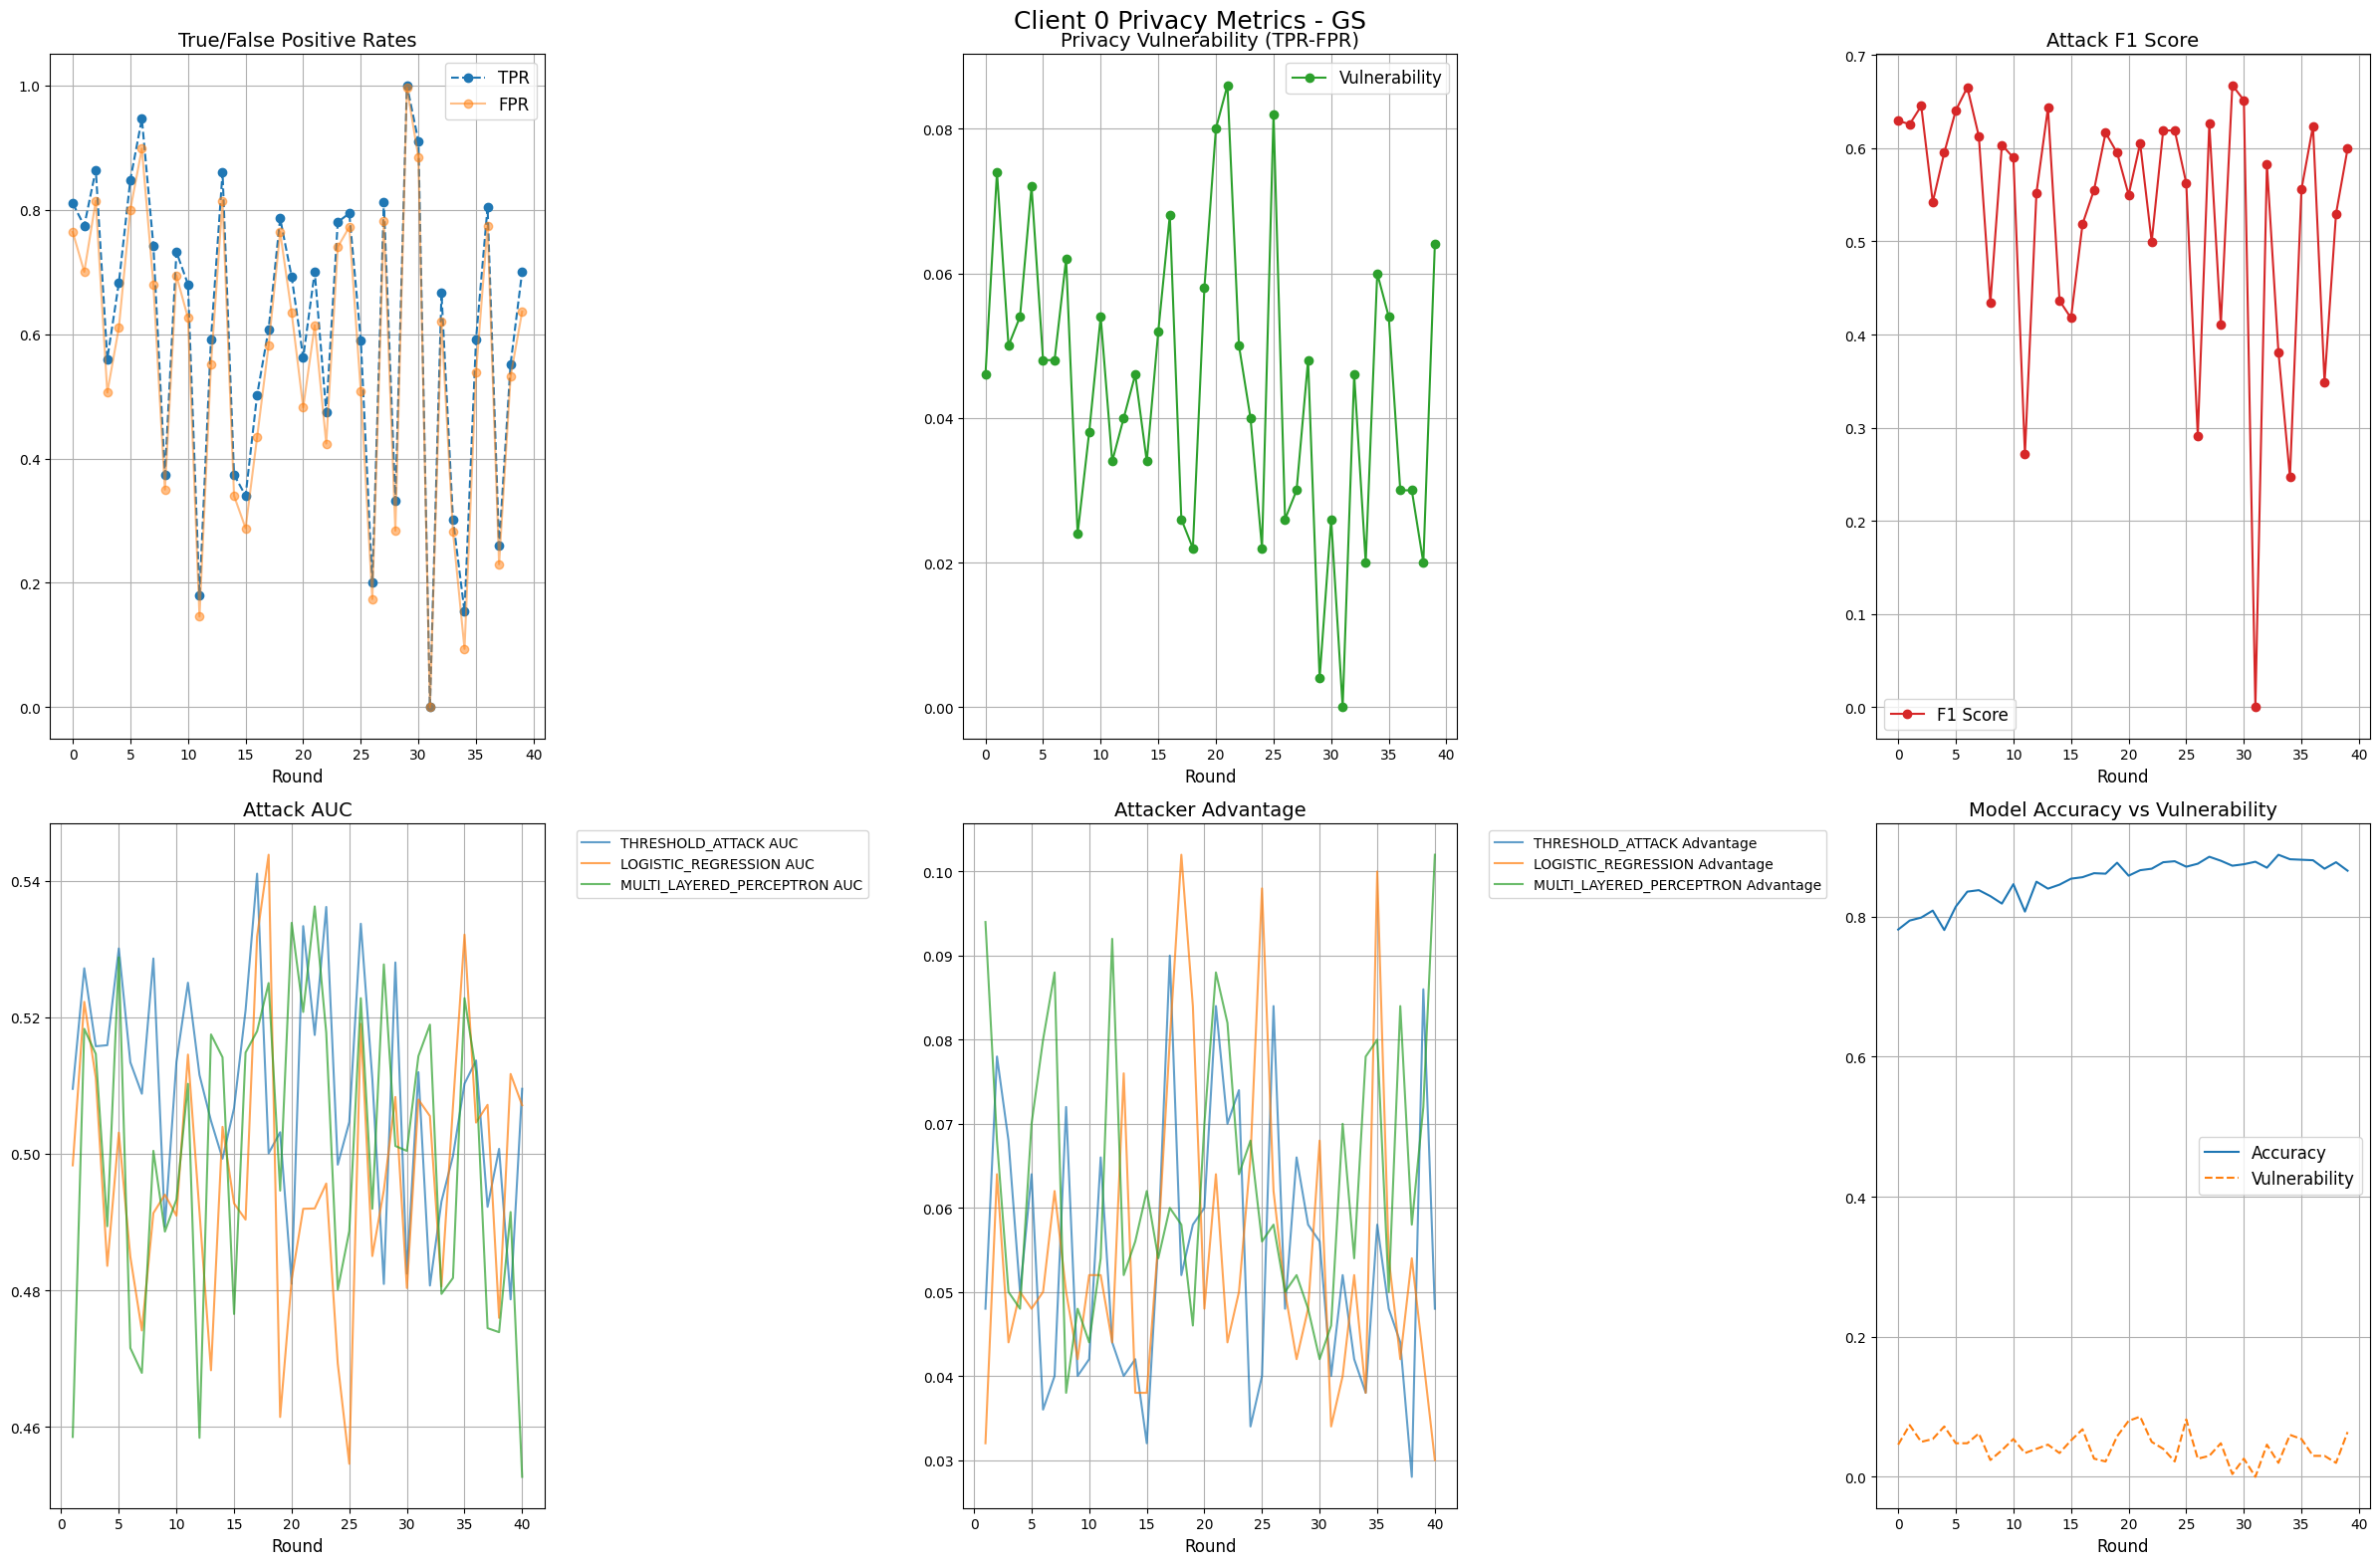

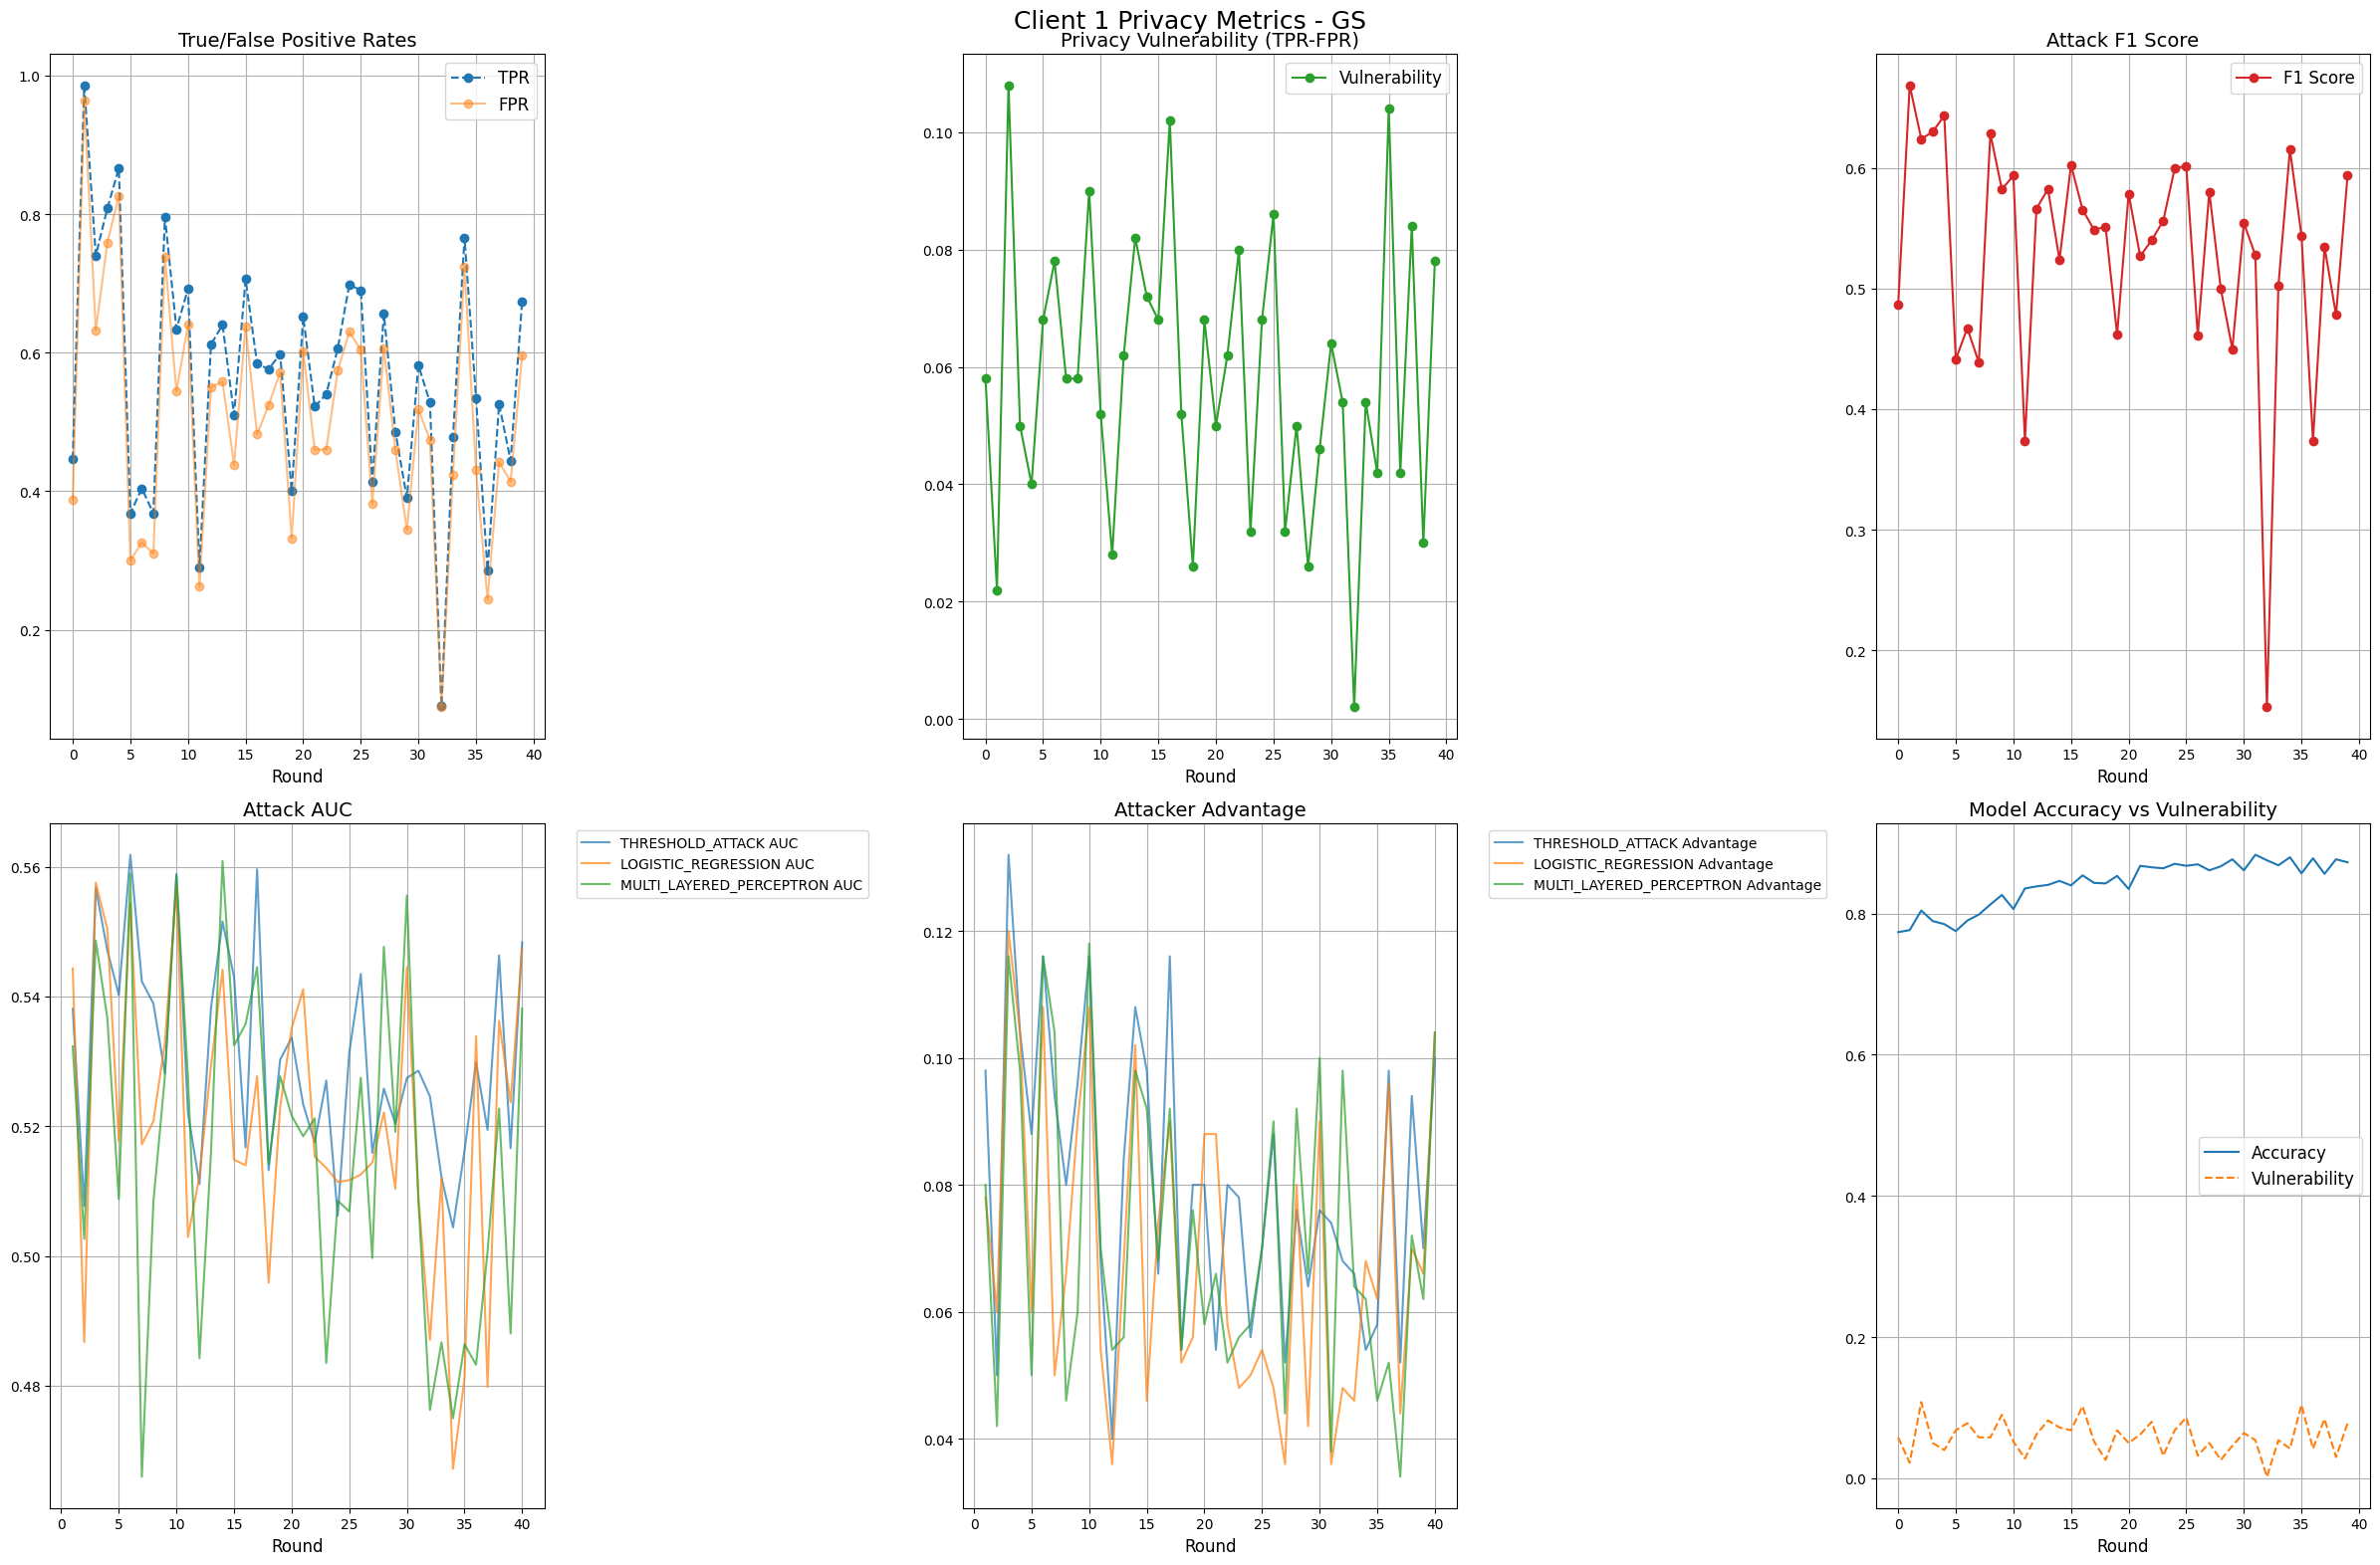

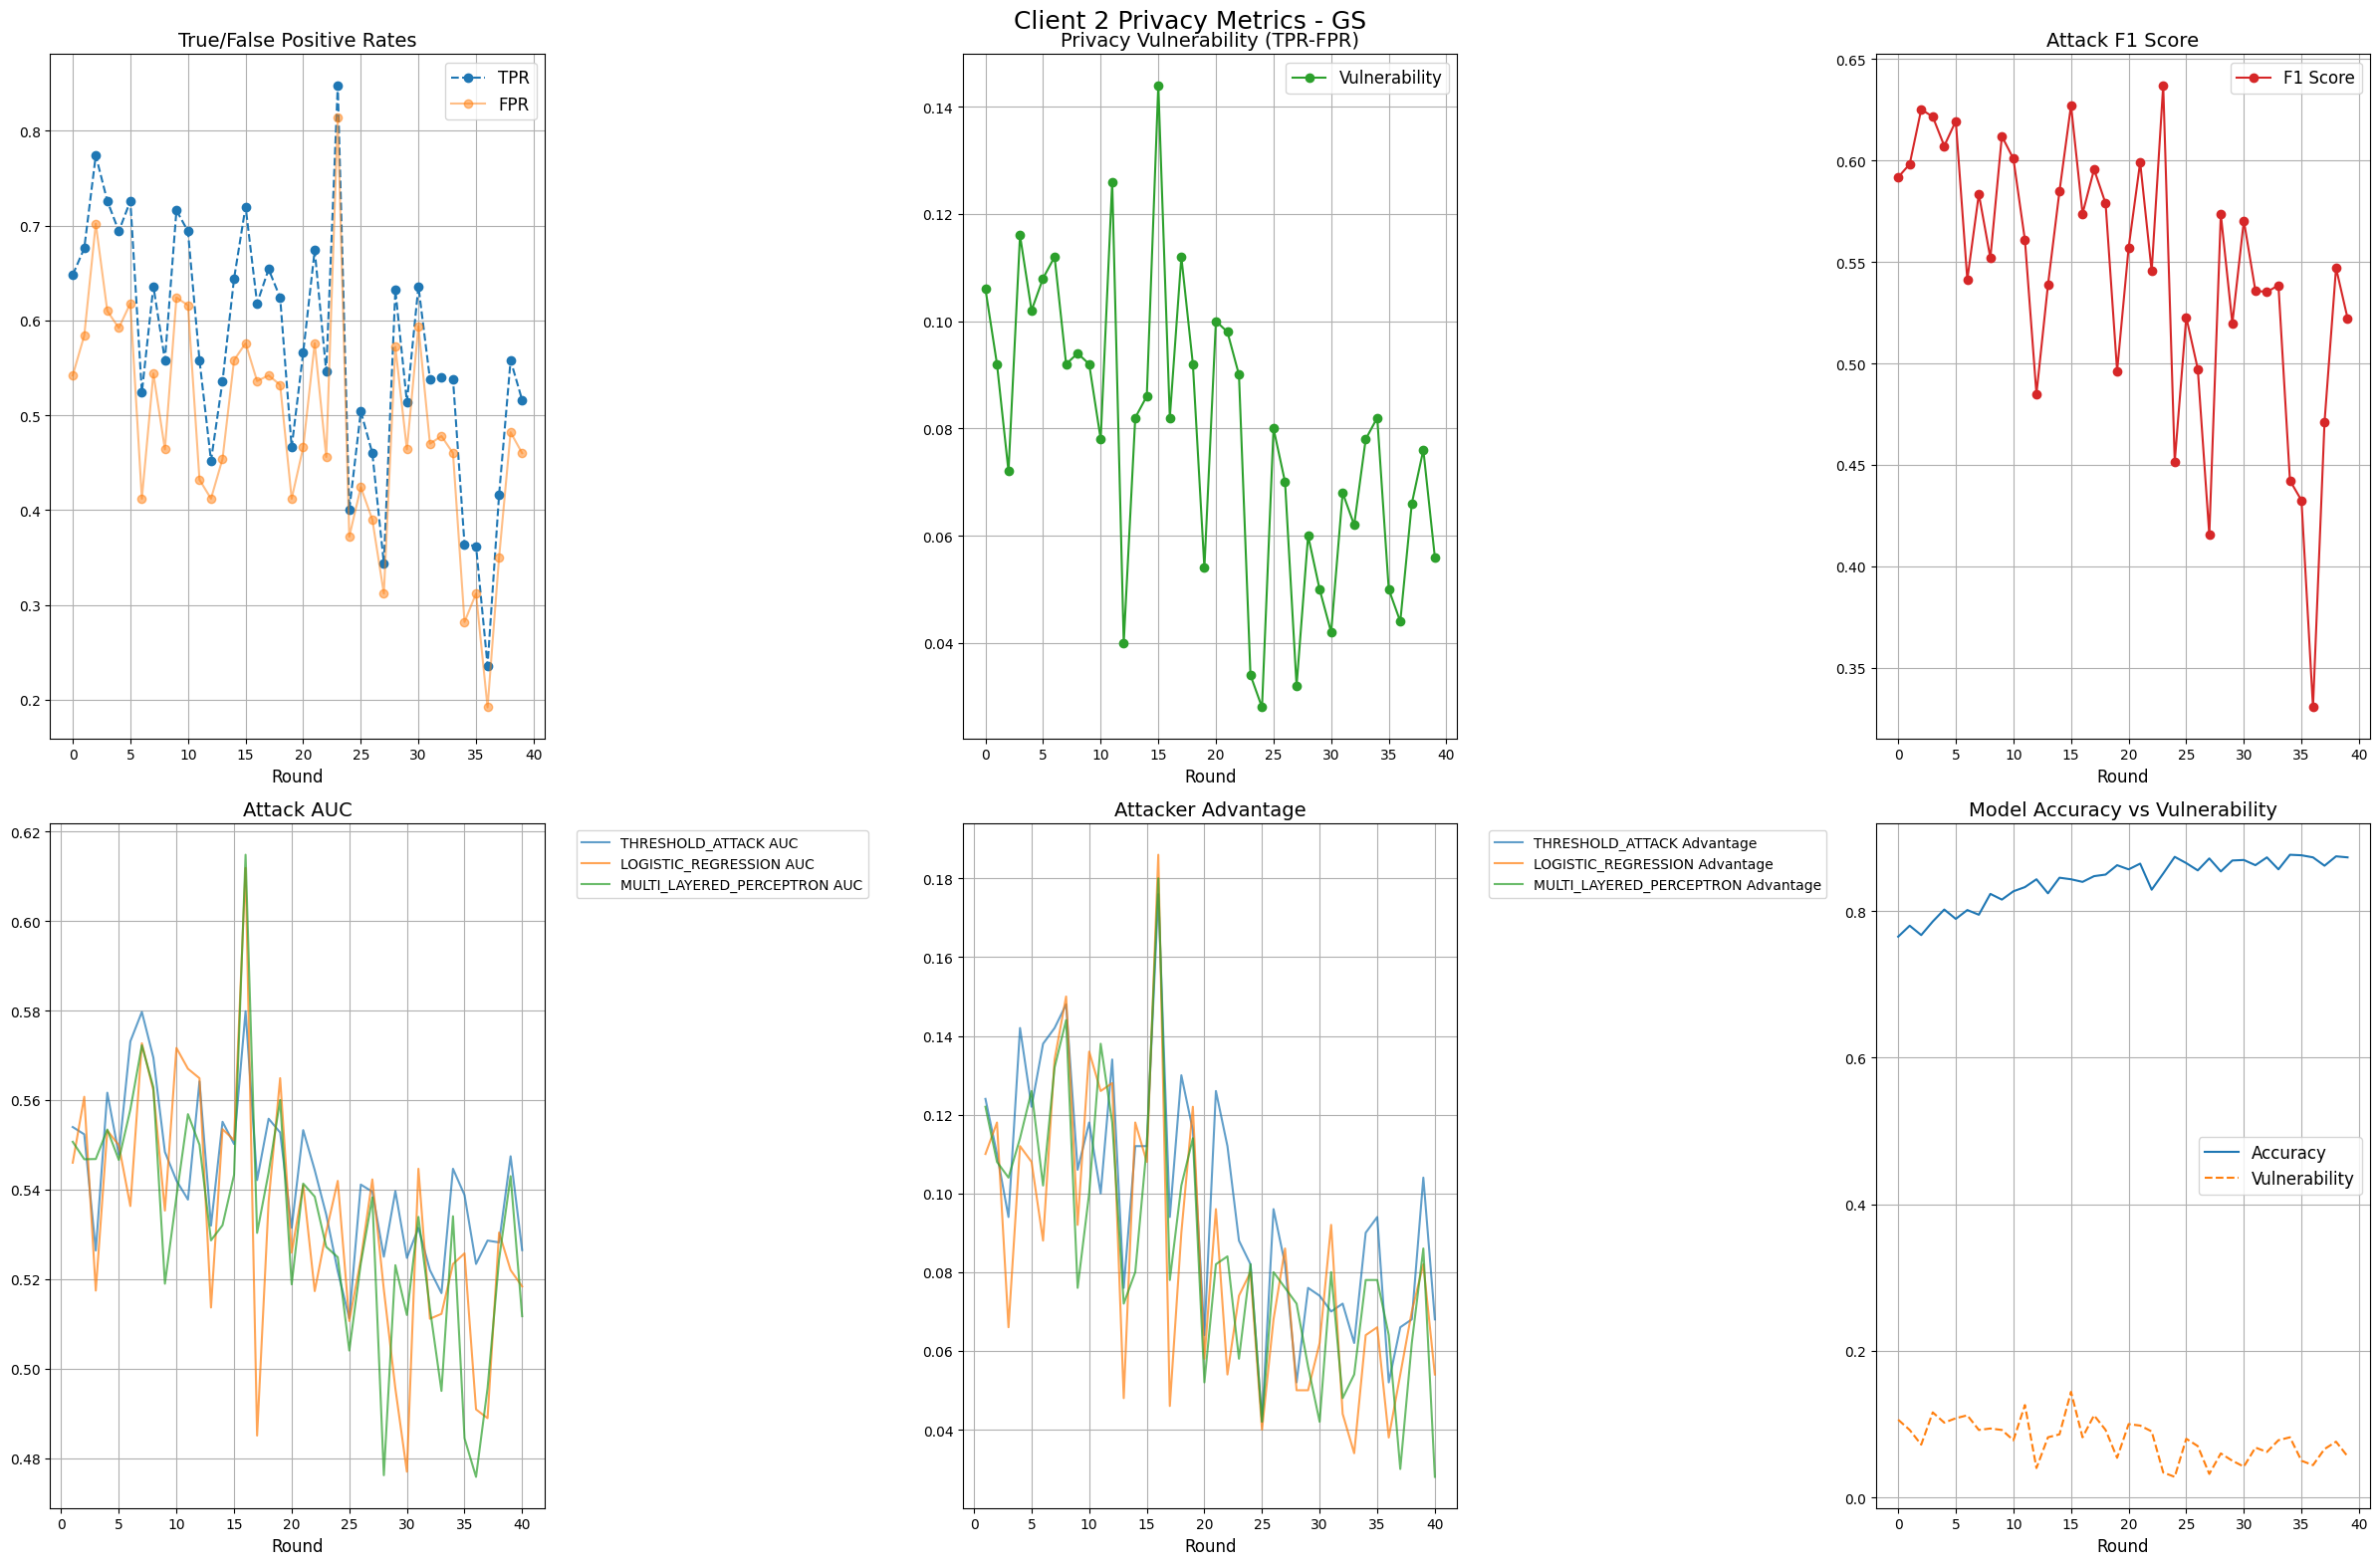

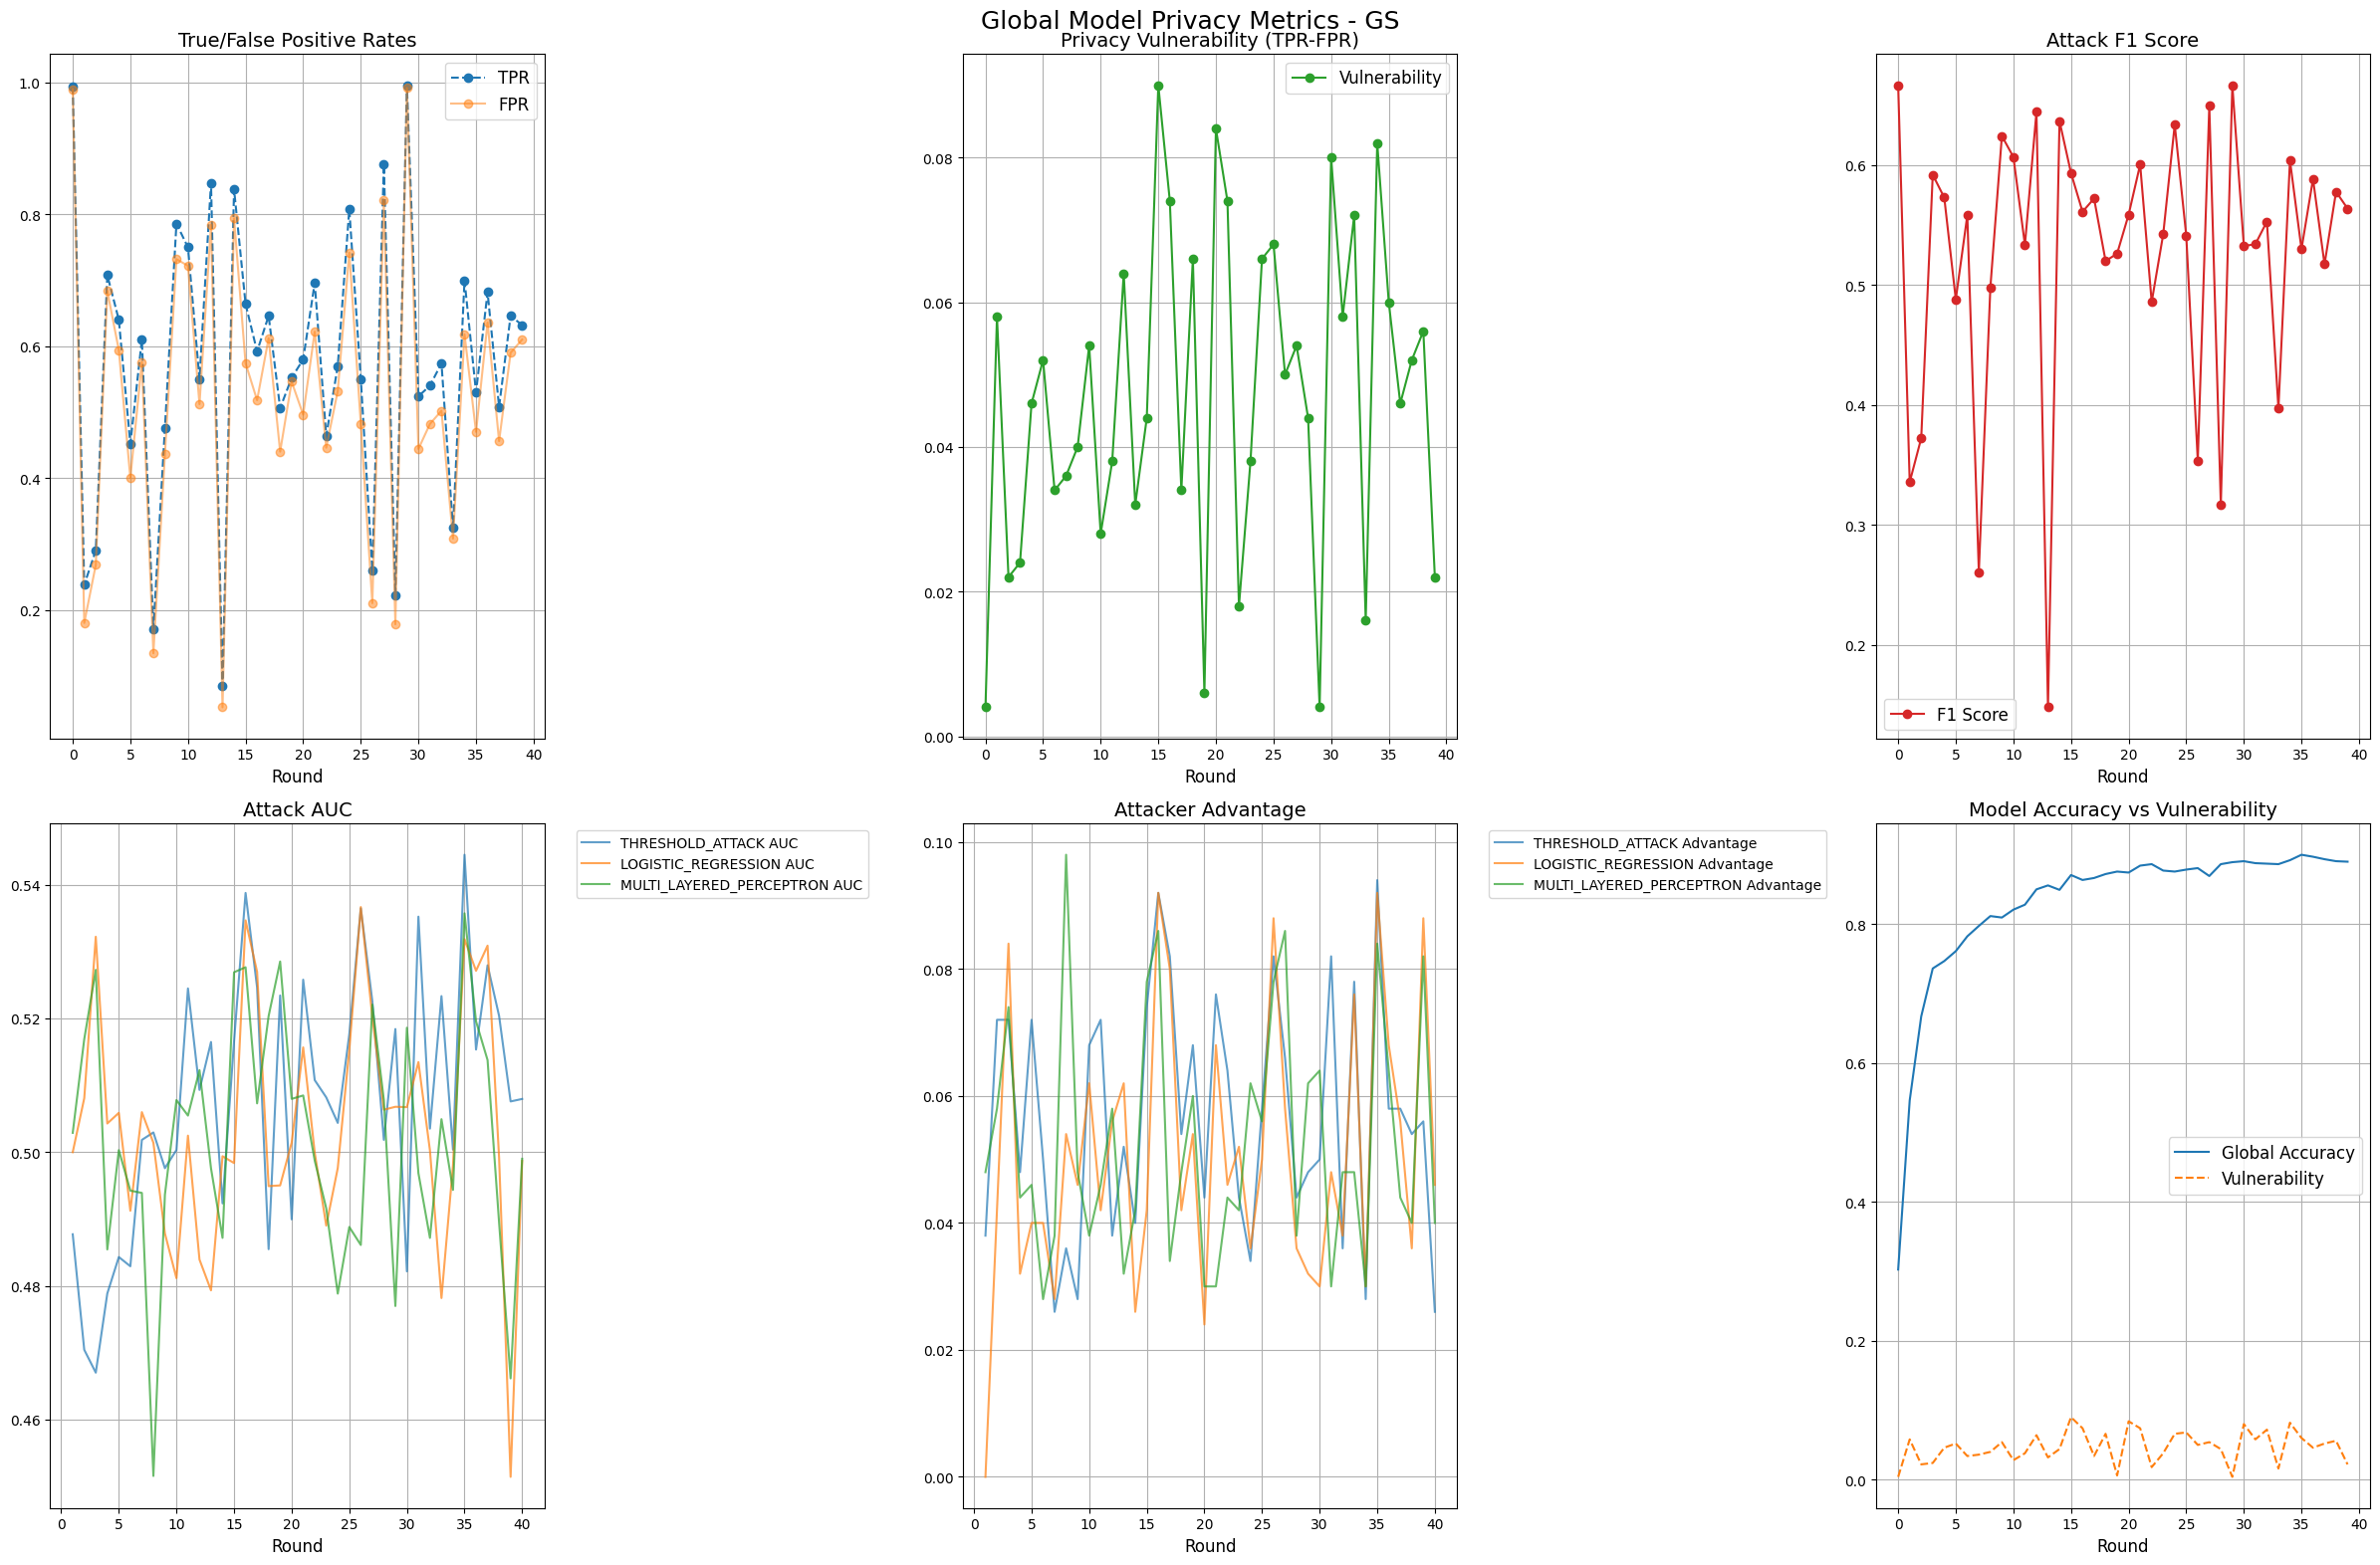

In [ ]:
visualize_privacy_metrics(privacy_evaluator,global_accuracies,client_accuracies, title_pref="GS")

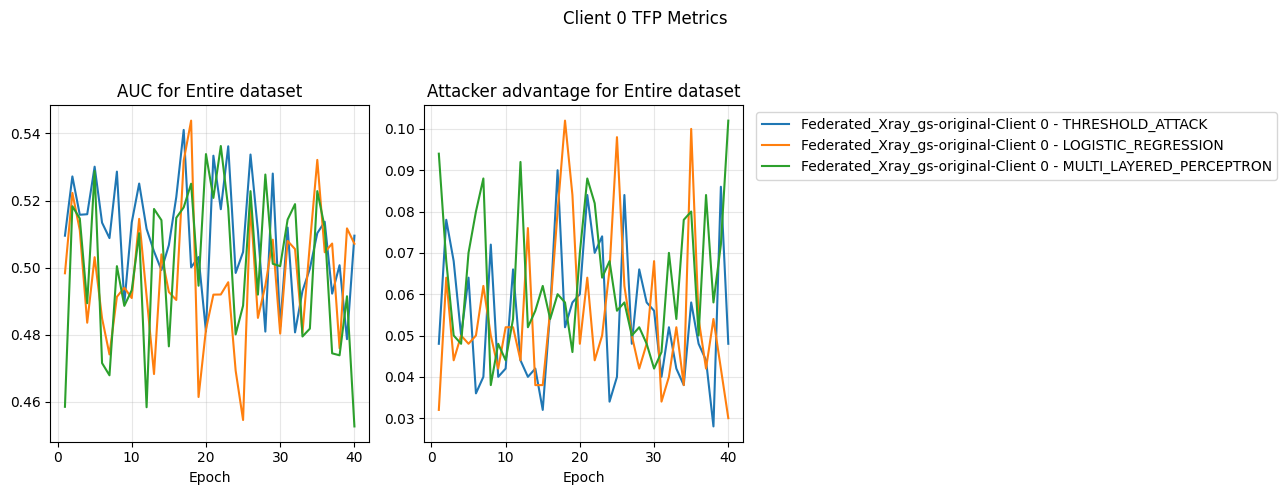

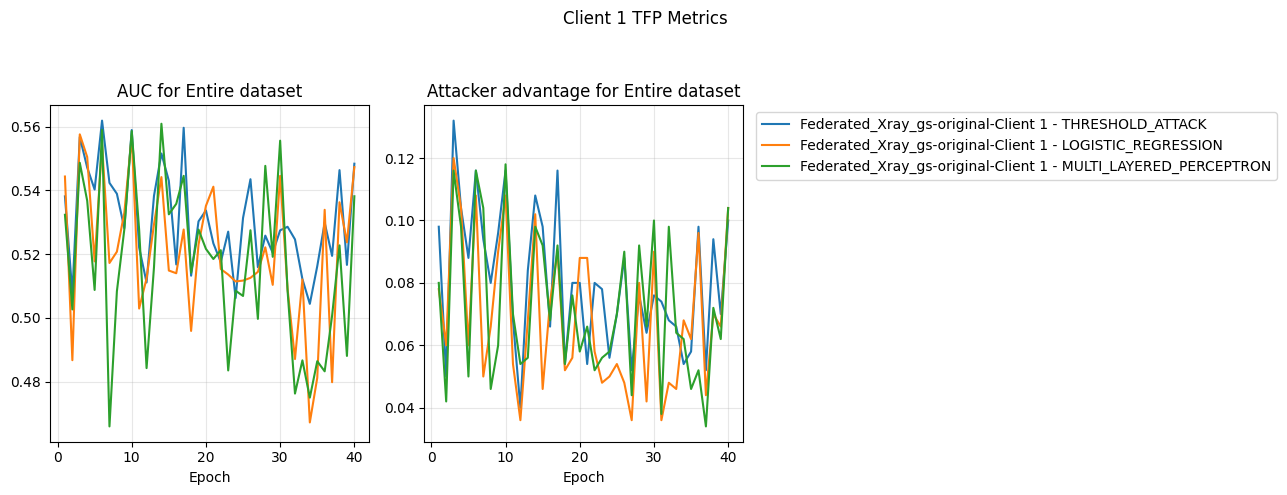

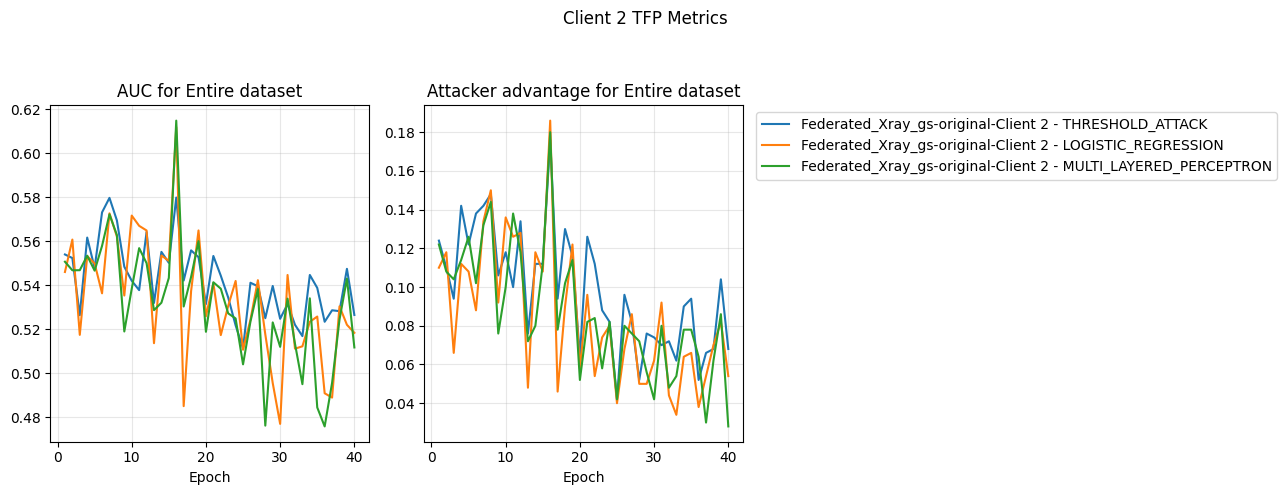

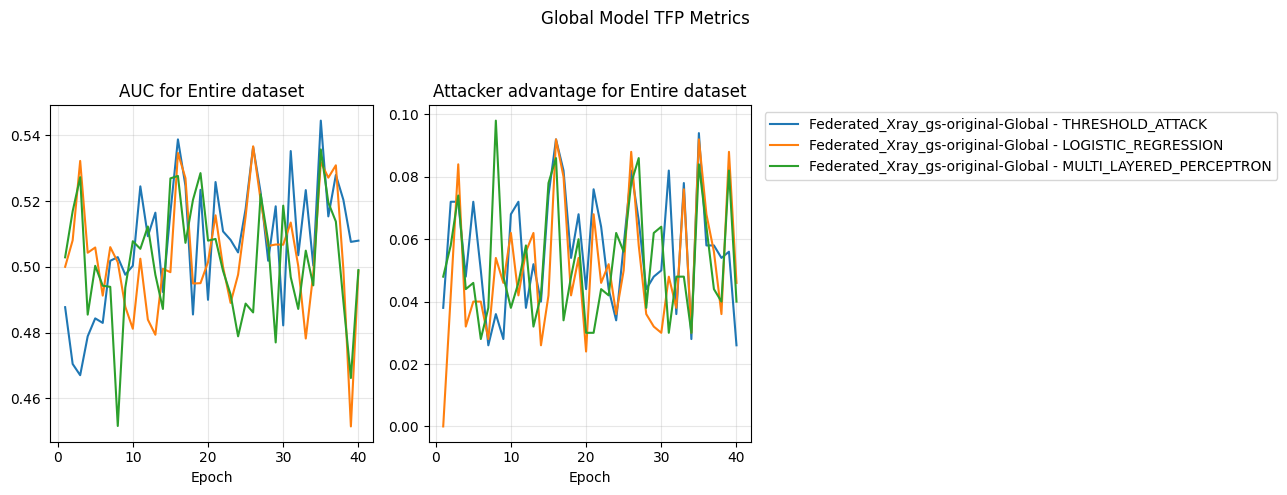

In [ ]:
visualize_default_mia(privacy_evaluator)

## Save Results

In [ ]:
class PicklableFederatedPrivacyEvaluator(FederatedPrivacyEvaluator):
    def __init__(self, original=None):
        if original is None:
            # Default constructor behavior for unpickling
            super().__init__(1, "placeholder")
            return

        # Copy from original
        self.epochs_per_report = original.epochs_per_report
        self.model_name = original.model_name
        self.batch_size = original.batch_size
        self.sample_size = original.sample_size

        # Copy results without lambda functions
        self.results = {
            'client': dict(original.results['client']),
            'global': dict(original.results['global'])
        }
        self.confusion_matrices = {
            'client': dict(original.confusion_matrices['client']),
            'global': dict(original.confusion_matrices['global'])
        }
        self.metrics = {
            'client': dict(),
            'global': dict()
        }
        self.thresholds = dict()
        for k, v in original.thresholds.items():
            self.thresholds[k] = {'client': dict(v['client']), 'global': v['global']}

def create_picklable_evaluator(privacy_evaluator):
    """Create a pickle-compatible version of the privacy evaluator"""
    return PicklableFederatedPrivacyEvaluator(privacy_evaluator)

pickleable_privacy_evaluator = create_picklable_evaluator(privacy_evaluator)

In [ ]:
pickle.dump(pickleable_privacy_evaluator, open('/github_brainfl/results/membership_inf/privacy_evaluator_gs20p.pickle','wb'),protocol=4) ## <- Replace
pickle.dump(global_accuracies, open('/github_brainfl/results/membership_inf/global_accuracies_gs20p.pickle','wb'),protocol=4) ## <-Replace
pickle.dump(client_accuracies, open('/github_brainfl/results/membership_inf/client_accuracies_gs20p.pickle','wb'),protocol=4) ## <- Replace